In [1]:
import pickle
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2
from tqdm import tqdm
import tensorflow as tf
from tensorflow.examples.tutorials.mnist import input_data
from tensorflow.contrib.layers import flatten
from IPython.display import HTML, display
import os
import pandas as pd
from sklearn import preprocessing
%matplotlib inline

In [2]:
"""
Functions for embeding tensorboard in Jupyter
"""
def strip_consts(graph_def, max_const_size=32):
    """Strip large constant values from graph_def."""
    strip_def = tf.GraphDef()
    for n0 in graph_def.node:
        n = strip_def.node.add() 
        n.MergeFrom(n0)
        if n.op == 'Const':
            tensor = n.attr['value'].tensor
            size = len(tensor.tensor_content)
            if size > max_const_size:
                tensor.tensor_content = "<stripped %d bytes>"%size
    return strip_def

def show_graph(graph_def, max_const_size=32):
    """Visualize TensorFlow graph."""
    if hasattr(graph_def, 'as_graph_def'):
        graph_def = graph_def.as_graph_def()
    strip_def = strip_consts(graph_def, max_const_size=max_const_size)
    code = """
        <script src="//cdnjs.cloudflare.com/ajax/libs/polymer/0.3.3/platform.js"></script>
        <script>
              function load() {{
                document.getElementById("{id}").pbtxt = {data};
              }}
        </script>
        
        <link rel="import" href="https://tensorboard.appspot.com/tf-graph-basic.build.html" onload=load()>
        
        <div style="height:600px">
              <tf-graph-basic id="{id}"></tf-graph-basic>
        </div>
    """.format(data=repr(str(strip_def)), id='graph'+str(np.random.rand()))

    iframe = """
        <iframe seamless style="width:1200px;height:620px;border:0" srcdoc="{}"></iframe>
    """.format(code.replace('"', '&quot;'))
    display(HTML(iframe))

In [140]:
# The code is from aleje. ref: https://github.com/aleju/imgaug
"""
Data augmentation

args: 
i: input images
o: the name of output file
m: minimum number of images for each class

yields:
images aftef affine transformation
"""
! python utility/dataAugmentation.py -i 'datasets//train.p' -o 'datasets//aug_train.p' -m 600

## Examples of data after data augmentation

In [2]:
display(HTML("<table><tr><td>Origin image</td><td>Affine Transformed images</td></tr> <tr><td><img src='./img/sample_traffic_sign.jpg' style='width: 500px;'></td><td><img src='./img/dataAugment.png' style='width: 500px;'></td></tr></table>"))

Origin image,Affine Transformed images
,


In [3]:
def read_data_sets(file):
    """
    Load pickled data
    args:
        file   (str)     path to datasets 
    yields:
        features and label of datasets (numpy array)
    """
    with open(file, mode='rb') as f:
        return pickle.load(f)

In [4]:
data_rel_path = "..\\..\\datasets_collection\\Traffic_Sign_Classifier"

train = read_data_sets(os.path.join(data_rel_path, "aug_train.p"))
valid= read_data_sets(os.path.join(data_rel_path, "valid.p")) 
test = read_data_sets(os.path.join(data_rel_path, "test.p")) 

signNames_pd = pd.read_csv(os.path.join(data_rel_path, "signnames.csv"))

In [5]:
image_shape = train['features'][0].shape
n_classes = len(signNames_pd["ClassId"])

In [6]:
def normalize(images):
    m = images.shape[0]
    flat_img = images.reshape((m,-1))
    _min = np.amin(images, axis=(1,2,3)).reshape(m,-1)
    _max = np.amax(images, axis=(1,2,3)).reshape(m,-1)
    norm_imgs = ((flat_img - _min) / (_max - _min))
    return norm_imgs.reshape(images.shape)

train['features'] = normalize(train['features']) 
test['features'] = normalize(test['features'])
valid['features'] = normalize(valid['features'])

In [7]:
def OneHotEncoding(y_class):
    lb = preprocessing.LabelBinarizer()
    lb.fit(y_class)
    return lb

In [9]:
ohe = OneHotEncoding(signNames_pd["ClassId"])

In [10]:
train['labels'] = ohe.transform(train['labels']).astype(np.float64)
valid['labels'] = ohe.transform(valid['labels']).astype(np.float64)
test['labels'] = ohe.transform(test['labels']).astype(np.float64)

In [11]:
from sklearn.model_selection import train_test_split
"""
shuffeling
"""
train['features'], valid['features'], train['labels'], valid['labels'] = train_test_split( train['features'], 
                                                                                           train['labels'],
                                                                                           test_size=0.2,
                                                                                           random_state=1)    

In [27]:
def conv2fc(input_height, input_width, filter_size, stride, layers):
    
    con2fc_height = input_height
    con2fc_width = input_width
    print (con2fc_height, con2fc_width)
    for i in layers:
        
        con2fc_height = np.ceil((con2fc_height - filter_size[i] + 1) / stride[i])
        con2fc_width = np.ceil((con2fc_width - filter_size[i] + 1) / stride[i])
        print (con2fc_height, con2fc_width)
    return int(con2fc_height) * int(con2fc_width)

In [21]:
def conv2d(x, W, b, strides=1):
    # Conv2D wrapper, with bias and relu activation
    x = tf.nn.conv2d(x, W, strides=[1, strides, strides, 1], padding='SAME')
    x = tf.nn.bias_add(x, b)
    return tf.nn.relu(x)

def maxpool2d(x, k=2):
    return tf.nn.max_pool(x, ksize=[1, k, k, 1], strides=[1, k, k, 1], padding='SAME')

def fclayer(x,w,b):
    return tf.nn.xw_plus_b(tf.contrib.layers.flatten(x), w, b)

In [22]:
def myNet(x):
    # conv layer
    net = conv2d(x,weights['conv1'],biases['conv1'])
    net = conv2d(net,weights['conv2'],biases['conv2'])

    # fully connected layers
    net = fclayer(net,weights['fc1'],biases['fc1'])
    net = tf.nn.relu(net)
    net = fclayer(net,weights['fc2'],biases['fc2'])
    net = tf.nn.relu(net)
    net = fclayer(net,weights['fc3'],biases['fc3'])

    return net

In [28]:
"""
Set neural network parameters
"""
EPOCHS = 4
BATCH_SIZE = 150
LEARNING_RATE = 0.0001

layers = ['conv_1', 'maxpool_1', 'conv_2', 'maxpool_2']

layer_input = {
     'depth': train['features'].shape[3]
    ,'height': train['features'].shape[1]
    ,'width': train['features'].shape[2]
}

layer_depth = {
    'conv1': 32,
    'conv2': 128,
    'fc1': 1024,
    'fc2': 1024,
    'fc3': n_classes
}

filter_size={
    'conv_1': 3
    ,'maxpool_1': 2
    ,'conv_2': 3
    ,'maxpool_2': 2
}

stride = {
    'conv_1': 1
    ,'maxpool_1': 2
    ,'conv_2': 1
    ,'maxpool_2': 2
}

conv2fc_num = conv2fc(layer_input["height"], layer_input["width"], filter_size, stride, layers)
print (conv2fc_num)

# xavier_initializer
# ref https://www.tensorflow.org/api_docs/python/tf/contrib/layers/xavier_initializer
# tf.truncated_normal(shape=[dims[l-1],dims[l]], mean=mu[l], stddev=std[l], dtype=tf.float64)


for key,val in sorted(layer_depth.items()):
    print("Layer %4s depth is %s"%(key,val))

32 32
30.0 30.0
15.0 15.0
13.0 13.0
6.0 6.0
36
Layer conv1 depth is 32
Layer conv2 depth is 128
Layer  fc1 depth is 1024
Layer  fc2 depth is 1024
Layer  fc3 depth is 43


In [29]:
saver = tf.train.Saver()

tf.reset_default_graph()
g = tf.Graph()
with g.as_default():
    x = tf.placeholder(tf.float32, shape=[None,image_shape[0],image_shape[1],image_shape[2]])  # (none, 32, 32, 3)
    y = tf.placeholder(tf.float32)

    with tf.variable_scope('Weight_Bias', reuse=False):
        weights = {
            'conv1': tf.get_variable("conv1w", shape=[filter_size['conv_1'], filter_size['conv_1'], image_shape[2], layer_depth['conv1']], initializer=tf.contrib.layers.xavier_initializer()),
            'conv2': tf.get_variable("conv2w", shape=[filter_size['conv_2'], filter_size['conv_2'], layer_depth['conv1'], layer_depth['conv2']], initializer=tf.contrib.layers.xavier_initializer()),
            'fc1':  tf.get_variable("fc1w", shape=[conv2fc_num*layer_depth['conv2'], layer_depth['fc1']], initializer=tf.contrib.layers.xavier_initializer()),
            'fc2':  tf.get_variable("fc2w", shape=[layer_depth['fc1'], layer_depth['fc2']], initializer=tf.contrib.layers.xavier_initializer()),
            'fc3':  tf.get_variable("fc3w", shape=[layer_depth['fc2'], layer_depth['fc3']], initializer=tf.contrib.layers.xavier_initializer())
        }
        #image_shape[0]*image_shape[1]*layer_depth['conv2']
        for key,val in sorted(weights.items()):
            print("Weights for %4s: %s"%(key,val))

        biases = {
            'conv1': tf.get_variable("conv1b", shape=[layer_depth['conv1']], initializer=tf.contrib.layers.xavier_initializer()),
            'conv2': tf.get_variable("conv2b", shape=[layer_depth['conv2']], initializer=tf.contrib.layers.xavier_initializer()),
            'fc1': tf.get_variable("fc1b", shape=[layer_depth['fc1']], initializer=tf.contrib.layers.xavier_initializer()),
            'fc2': tf.get_variable("fc2b", shape=[layer_depth['fc2']], initializer=tf.contrib.layers.xavier_initializer()),
            'fc3': tf.get_variable("fc3b", shape=[layer_depth['fc3']], initializer=tf.contrib.layers.xavier_initializer())
        }


    with tf.name_scope('Model'):
        net = myNet(x)

    # Loss computation
    with tf.name_scope('Loss'):
        prediction = tf.nn.softmax(net)
        cross_entropy = -tf.reduce_sum(y * tf.log(prediction + 1e-6), reduction_indices=1)
        loss = tf.reduce_mean(cross_entropy)

    # Accuracy computation
    with tf.name_scope('Accuracy'):
        is_correct_prediction = tf.equal(tf.argmax(prediction, 1), tf.argmax(y, 1))
        accuracy = tf.reduce_mean(tf.cast(is_correct_prediction, tf.float32))
    with tf.name_scope('SGD'):
        optimizer = tf.train.AdamOptimizer(LEARNING_RATE).minimize(loss)        
        
    # Create a summary to monitor cost tensor
    tf.summary.scalar("loss", loss)
    # Create a summary to monitor accuracy tensor
    tf.summary.scalar("accuracy", accuracy)
    # Merge all summaries into a single op
    merged_summary_op = tf.summary.merge_all()
#     tf.summary.FileWriter("logs", g).close()

ValueError: No variables to save

In [52]:
batches = []
loss_epoch = []
train_acc_epoch = []
valid_acc_epoch = []
validation_accuracy = 0.0


batch_count = int(len(train['features']) / BATCH_SIZE)

# Start training
with tf.Session(graph=g, config=tf.ConfigProto(log_device_placement=True)) as sess:
    # Initialize the variables (i.e. assign their default value)
    init = tf.global_variables_initializer()

    # Run the initializer
    sess.run(init)

    # op to write logs to Tensorboard
    train_writer = tf.summary.FileWriter("logs", g)

    for epoch in range(EPOCHS):
        batches_pbar = tqdm(range(batch_count), desc='Epoch {:>2}/{}'.format(epoch + 1, EPOCHS), unit='batches')

        for batch_i in batches_pbar:
            batch_start = batch_i * BATCH_SIZE
            batch_features = train['features'][batch_start:batch_start + BATCH_SIZE]
            batch_labels = train['labels'][batch_start:batch_start + BATCH_SIZE]

            _, l, summary = sess.run(
                [optimizer, loss, merged_summary_op],
                feed_dict={x: batch_features, y: batch_labels})
            print (epoch * BATCH_SIZE + batch_i)
            train_writer.add_summary(summary, epoch * BATCH_SIZE + batch_i)

        training_accuracy = sess.run(
            accuracy,
            feed_dict={x: batch_features, y: batch_labels}
        )

        idx = np.random.randint(len(valid['features']), size=int(BATCH_SIZE * .2))

        validation_accuracy = sess.run(
            accuracy,
            feed_dict={x: valid['features'][idx,:], y: valid['labels'][idx,:]}
        )

        print('Epoch {:>2}/{}'.format(epoch + 1, EPOCHS))
        print("loss is {}".format(l))
        print("training set accuracy is {}".format(training_accuracy))
        print("validation set accuracy is {}".format(validation_accuracy))


        batches.append(len(batches))
        loss_epoch.append(l)
        train_acc_epoch.append(training_accuracy)
        valid_acc_epoch.append(validation_accuracy)
    
    # Save model weights to disk
    model_path = "/tmp/model_valid_{0:.2f}.ckpt".format(validation_accuracy)
    save_path = saver.save(sess, model_path)
    print("Model saved in file: %s" % save_path)


Epoch  1/4:   0%|                                 | 0/221 [00:00<?, ?batches/s]


0


Epoch  1/4:   0%|                         | 1/221 [00:03<14:01,  3.82s/batches]

1


Epoch  1/4:   1%|▏                        | 2/221 [00:07<13:34,  3.72s/batches]

2


Epoch  1/4:   1%|▎                        | 3/221 [00:10<13:15,  3.65s/batches]

3


Epoch  1/4:   2%|▍                        | 4/221 [00:14<12:55,  3.57s/batches]

4


Epoch  1/4:   2%|▌                        | 5/221 [00:17<12:24,  3.45s/batches]

5


Epoch  1/4:   3%|▋                        | 6/221 [00:20<12:16,  3.43s/batches]

6


Epoch  1/4:   3%|▊                        | 7/221 [00:24<12:12,  3.42s/batches]

7


Epoch  1/4:   4%|▉                        | 8/221 [00:27<11:43,  3.30s/batches]

8


Epoch  1/4:   4%|█                        | 9/221 [00:30<11:24,  3.23s/batches]

9


Epoch  1/4:   5%|█                       | 10/221 [00:33<11:14,  3.20s/batches]

10


Epoch  1/4:   5%|█▏                      | 11/221 [00:36<11:00,  3.15s/batches]

11


Epoch  1/4:   5%|█▎                      | 12/221 [00:39<10:51,  3.12s/batches]

12


Epoch  1/4:   6%|█▍                      | 13/221 [00:42<10:47,  3.11s/batches]

13


Epoch  1/4:   6%|█▌                      | 14/221 [00:45<10:40,  3.10s/batches]

14


Epoch  1/4:   7%|█▋                      | 15/221 [00:48<10:39,  3.10s/batches]

15


Epoch  1/4:   7%|█▋                      | 16/221 [00:51<10:40,  3.12s/batches]

16


Epoch  1/4:   8%|█▊                      | 17/221 [00:54<10:33,  3.11s/batches]

17


Epoch  1/4:   8%|█▉                      | 18/221 [00:58<10:28,  3.10s/batches]

18


Epoch  1/4:   9%|██                      | 19/221 [01:01<10:23,  3.09s/batches]

19


Epoch  1/4:   9%|██▏                     | 20/221 [01:04<10:21,  3.09s/batches]

20


Epoch  1/4:  10%|██▎                     | 21/221 [01:07<10:14,  3.07s/batches]

21


Epoch  1/4:  10%|██▍                     | 22/221 [01:10<10:22,  3.13s/batches]

22


Epoch  1/4:  10%|██▍                     | 23/221 [01:13<10:21,  3.14s/batches]

23


Epoch  1/4:  11%|██▌                     | 24/221 [01:16<10:12,  3.11s/batches]

24


Epoch  1/4:  11%|██▋                     | 25/221 [01:19<10:11,  3.12s/batches]

25


Epoch  1/4:  12%|██▊                     | 26/221 [01:22<10:04,  3.10s/batches]

26


Epoch  1/4:  12%|██▉                     | 27/221 [01:25<10:01,  3.10s/batches]

27


Epoch  1/4:  13%|███                     | 28/221 [01:29<09:55,  3.09s/batches]

28


Epoch  1/4:  13%|███▏                    | 29/221 [01:32<09:52,  3.08s/batches]

29


Epoch  1/4:  14%|███▎                    | 30/221 [01:35<09:46,  3.07s/batches]

30


Epoch  1/4:  14%|███▎                    | 31/221 [01:38<09:42,  3.06s/batches]

31


Epoch  1/4:  14%|███▍                    | 32/221 [01:41<09:39,  3.06s/batches]

32


Epoch  1/4:  15%|███▌                    | 33/221 [01:44<09:36,  3.07s/batches]

33


Epoch  1/4:  15%|███▋                    | 34/221 [01:47<09:30,  3.05s/batches]

34


Epoch  1/4:  16%|███▊                    | 35/221 [01:50<09:24,  3.04s/batches]

35


Epoch  1/4:  16%|███▉                    | 36/221 [01:53<09:22,  3.04s/batches]

36


Epoch  1/4:  17%|████                    | 37/221 [01:56<09:24,  3.07s/batches]

37


Epoch  1/4:  17%|████▏                   | 38/221 [01:59<09:17,  3.05s/batches]

38


Epoch  1/4:  18%|████▏                   | 39/221 [02:02<09:15,  3.05s/batches]

39


Epoch  1/4:  18%|████▎                   | 40/221 [02:05<09:13,  3.06s/batches]

40


Epoch  1/4:  19%|████▍                   | 41/221 [02:08<09:07,  3.04s/batches]

41


Epoch  1/4:  19%|████▌                   | 42/221 [02:11<09:05,  3.05s/batches]

42


Epoch  1/4:  19%|████▋                   | 43/221 [02:14<09:02,  3.05s/batches]

43


Epoch  1/4:  20%|████▊                   | 44/221 [02:17<09:03,  3.07s/batches]

44


Epoch  1/4:  20%|████▉                   | 45/221 [02:20<08:57,  3.06s/batches]

45


Epoch  1/4:  21%|████▉                   | 46/221 [02:23<08:52,  3.04s/batches]

46


Epoch  1/4:  21%|█████                   | 47/221 [02:26<08:50,  3.05s/batches]

47


Epoch  1/4:  22%|█████▏                  | 48/221 [02:30<08:47,  3.05s/batches]

48


Epoch  1/4:  22%|█████▎                  | 49/221 [02:33<08:45,  3.05s/batches]

49


Epoch  1/4:  23%|█████▍                  | 50/221 [02:36<08:46,  3.08s/batches]

50


Epoch  1/4:  23%|█████▌                  | 51/221 [02:39<08:41,  3.07s/batches]

51


Epoch  1/4:  24%|█████▋                  | 52/221 [02:42<08:36,  3.05s/batches]

52


Epoch  1/4:  24%|█████▊                  | 53/221 [02:45<08:32,  3.05s/batches]

53


Epoch  1/4:  24%|█████▊                  | 54/221 [02:48<08:29,  3.05s/batches]

54


Epoch  1/4:  25%|█████▉                  | 55/221 [02:51<08:25,  3.04s/batches]

55


Epoch  1/4:  25%|██████                  | 56/221 [02:54<08:20,  3.03s/batches]

56


Epoch  1/4:  26%|██████▏                 | 57/221 [02:57<08:15,  3.02s/batches]

57


Epoch  1/4:  26%|██████▎                 | 58/221 [03:00<08:18,  3.06s/batches]

58


Epoch  1/4:  27%|██████▍                 | 59/221 [03:03<08:16,  3.06s/batches]

59


Epoch  1/4:  27%|██████▌                 | 60/221 [03:06<08:13,  3.06s/batches]

60


Epoch  1/4:  28%|██████▌                 | 61/221 [03:09<08:09,  3.06s/batches]

61


Epoch  1/4:  28%|██████▋                 | 62/221 [03:12<08:06,  3.06s/batches]

62


Epoch  1/4:  29%|██████▊                 | 63/221 [03:15<08:01,  3.05s/batches]

63


Epoch  1/4:  29%|██████▉                 | 64/221 [03:18<07:57,  3.04s/batches]

64


Epoch  1/4:  29%|███████                 | 65/221 [03:21<07:54,  3.04s/batches]

65


Epoch  1/4:  30%|███████▏                | 66/221 [03:24<07:53,  3.06s/batches]

66


Epoch  1/4:  30%|███████▎                | 67/221 [03:28<07:50,  3.05s/batches]

67


Epoch  1/4:  31%|███████▍                | 68/221 [03:31<07:48,  3.06s/batches]

68


Epoch  1/4:  31%|███████▍                | 69/221 [03:34<07:44,  3.06s/batches]

69


Epoch  1/4:  32%|███████▌                | 70/221 [03:37<07:40,  3.05s/batches]

70


Epoch  1/4:  32%|███████▋                | 71/221 [03:40<07:34,  3.03s/batches]

71


Epoch  1/4:  33%|███████▊                | 72/221 [03:43<07:32,  3.03s/batches]

72


Epoch  1/4:  33%|███████▉                | 73/221 [03:46<07:27,  3.03s/batches]

73


Epoch  1/4:  33%|████████                | 74/221 [03:49<07:23,  3.02s/batches]

74


Epoch  1/4:  34%|████████▏               | 75/221 [03:52<07:19,  3.01s/batches]

75


Epoch  1/4:  34%|████████▎               | 76/221 [03:55<07:17,  3.01s/batches]

76


Epoch  1/4:  35%|████████▎               | 77/221 [03:58<07:15,  3.02s/batches]

77


Epoch  1/4:  35%|████████▍               | 78/221 [04:01<07:11,  3.02s/batches]

78


Epoch  1/4:  36%|████████▌               | 79/221 [04:04<07:10,  3.03s/batches]

79


Epoch  1/4:  36%|████████▋               | 80/221 [04:07<07:14,  3.08s/batches]

80


Epoch  1/4:  37%|████████▊               | 81/221 [04:10<07:09,  3.07s/batches]

81


Epoch  1/4:  37%|████████▉               | 82/221 [04:13<07:03,  3.05s/batches]

82


Epoch  1/4:  38%|█████████               | 83/221 [04:16<07:00,  3.05s/batches]

83


Epoch  1/4:  38%|█████████               | 84/221 [04:19<06:58,  3.05s/batches]

84


Epoch  1/4:  38%|█████████▏              | 85/221 [04:22<06:57,  3.07s/batches]

85


Epoch  1/4:  39%|█████████▎              | 86/221 [04:25<06:53,  3.06s/batches]

86


Epoch  1/4:  39%|█████████▍              | 87/221 [04:28<06:50,  3.06s/batches]

87


Epoch  1/4:  40%|█████████▌              | 88/221 [04:31<06:47,  3.06s/batches]

88


Epoch  1/4:  40%|█████████▋              | 89/221 [04:35<06:43,  3.05s/batches]

89


Epoch  1/4:  41%|█████████▊              | 90/221 [04:38<06:42,  3.07s/batches]

90


Epoch  1/4:  41%|█████████▉              | 91/221 [04:41<06:40,  3.08s/batches]

91


Epoch  1/4:  42%|█████████▉              | 92/221 [04:44<06:34,  3.06s/batches]

92


Epoch  1/4:  42%|██████████              | 93/221 [04:47<06:28,  3.04s/batches]

93


Epoch  1/4:  43%|██████████▏             | 94/221 [04:50<06:24,  3.03s/batches]

94


Epoch  1/4:  43%|██████████▎             | 95/221 [04:53<06:20,  3.02s/batches]

95


Epoch  1/4:  43%|██████████▍             | 96/221 [04:56<06:18,  3.03s/batches]

96


Epoch  1/4:  44%|██████████▌             | 97/221 [04:59<06:15,  3.03s/batches]

97


Epoch  1/4:  44%|██████████▋             | 98/221 [05:02<06:11,  3.02s/batches]

98


Epoch  1/4:  45%|██████████▊             | 99/221 [05:05<06:08,  3.02s/batches]

99


Epoch  1/4:  45%|██████████▍            | 100/221 [05:08<06:05,  3.02s/batches]

100


Epoch  1/4:  46%|██████████▌            | 101/221 [05:11<06:07,  3.06s/batches]

101


Epoch  1/4:  46%|██████████▌            | 102/221 [05:14<06:04,  3.06s/batches]

102


Epoch  1/4:  47%|██████████▋            | 103/221 [05:17<05:59,  3.05s/batches]

103


Epoch  1/4:  47%|██████████▊            | 104/221 [05:20<05:57,  3.05s/batches]

104


Epoch  1/4:  48%|██████████▉            | 105/221 [05:23<05:56,  3.07s/batches]

105


Epoch  1/4:  48%|███████████            | 106/221 [05:26<05:53,  3.07s/batches]

106


Epoch  1/4:  48%|███████████▏           | 107/221 [05:29<05:51,  3.08s/batches]

107


Epoch  1/4:  49%|███████████▏           | 108/221 [05:32<05:46,  3.07s/batches]

108


Epoch  1/4:  49%|███████████▎           | 109/221 [05:36<05:51,  3.14s/batches]

109


Epoch  1/4:  50%|███████████▍           | 110/221 [05:39<05:46,  3.12s/batches]

110


Epoch  1/4:  50%|███████████▌           | 111/221 [05:42<05:39,  3.09s/batches]

111


Epoch  1/4:  51%|███████████▋           | 112/221 [05:45<05:33,  3.06s/batches]

112


Epoch  1/4:  51%|███████████▊           | 113/221 [05:48<05:29,  3.05s/batches]

113


Epoch  1/4:  52%|███████████▊           | 114/221 [05:51<05:26,  3.05s/batches]

114


Epoch  1/4:  52%|███████████▉           | 115/221 [05:54<05:25,  3.07s/batches]

115


Epoch  1/4:  52%|████████████           | 116/221 [05:57<05:22,  3.07s/batches]

116


Epoch  1/4:  53%|████████████▏          | 117/221 [06:00<05:18,  3.07s/batches]

117


Epoch  1/4:  53%|████████████▎          | 118/221 [06:03<05:17,  3.08s/batches]

118


Epoch  1/4:  54%|████████████▍          | 119/221 [06:06<05:12,  3.07s/batches]

119


Epoch  1/4:  54%|████████████▍          | 120/221 [06:10<05:15,  3.12s/batches]

120


Epoch  1/4:  55%|████████████▌          | 121/221 [06:13<05:12,  3.12s/batches]

121


Epoch  1/4:  55%|████████████▋          | 122/221 [06:16<05:12,  3.15s/batches]

122


Epoch  1/4:  56%|████████████▊          | 123/221 [06:19<05:07,  3.13s/batches]

123


Epoch  1/4:  56%|████████████▉          | 124/221 [06:22<05:00,  3.10s/batches]

124


Epoch  1/4:  57%|█████████████          | 125/221 [06:25<04:55,  3.08s/batches]

125


Epoch  1/4:  57%|█████████████          | 126/221 [06:28<04:51,  3.07s/batches]

126


Epoch  1/4:  57%|█████████████▏         | 127/221 [06:31<04:47,  3.05s/batches]

127


Epoch  1/4:  58%|█████████████▎         | 128/221 [06:34<04:43,  3.05s/batches]

128


Epoch  1/4:  58%|█████████████▍         | 129/221 [06:37<04:42,  3.07s/batches]

129


Epoch  1/4:  59%|█████████████▌         | 130/221 [06:40<04:40,  3.08s/batches]

130


Epoch  1/4:  59%|█████████████▋         | 131/221 [06:43<04:36,  3.07s/batches]

131


Epoch  1/4:  60%|█████████████▋         | 132/221 [06:46<04:32,  3.06s/batches]

132


Epoch  1/4:  60%|█████████████▊         | 133/221 [06:50<04:28,  3.05s/batches]

133


Epoch  1/4:  61%|█████████████▉         | 134/221 [06:53<04:24,  3.04s/batches]

134


Epoch  1/4:  61%|██████████████         | 135/221 [06:56<04:20,  3.03s/batches]

135


Epoch  1/4:  62%|██████████████▏        | 136/221 [06:59<04:17,  3.03s/batches]

136


Epoch  1/4:  62%|██████████████▎        | 137/221 [07:02<04:15,  3.04s/batches]

137


Epoch  1/4:  62%|██████████████▎        | 138/221 [07:05<04:11,  3.03s/batches]

138


Epoch  1/4:  63%|██████████████▍        | 139/221 [07:08<04:07,  3.02s/batches]

139


Epoch  1/4:  63%|██████████████▌        | 140/221 [07:11<04:04,  3.02s/batches]

140


Epoch  1/4:  64%|██████████████▋        | 141/221 [07:14<04:01,  3.02s/batches]

141


Epoch  1/4:  64%|██████████████▊        | 142/221 [07:17<03:58,  3.02s/batches]

142


Epoch  1/4:  65%|██████████████▉        | 143/221 [07:20<03:56,  3.03s/batches]

143


Epoch  1/4:  65%|██████████████▉        | 144/221 [07:23<03:54,  3.05s/batches]

144


Epoch  1/4:  66%|███████████████        | 145/221 [07:26<03:50,  3.04s/batches]

145


Epoch  1/4:  66%|███████████████▏       | 146/221 [07:29<03:47,  3.03s/batches]

146


Epoch  1/4:  67%|███████████████▎       | 147/221 [07:32<03:44,  3.04s/batches]

147


Epoch  1/4:  67%|███████████████▍       | 148/221 [07:35<03:41,  3.03s/batches]

148


Epoch  1/4:  67%|███████████████▌       | 149/221 [07:38<03:39,  3.05s/batches]

149


Epoch  1/4:  68%|███████████████▌       | 150/221 [07:41<03:35,  3.04s/batches]

150


Epoch  1/4:  68%|███████████████▋       | 151/221 [07:44<03:32,  3.04s/batches]

151


Epoch  1/4:  69%|███████████████▊       | 152/221 [07:47<03:30,  3.05s/batches]

152


Epoch  1/4:  69%|███████████████▉       | 153/221 [07:50<03:27,  3.05s/batches]

153


Epoch  1/4:  70%|████████████████       | 154/221 [07:53<03:24,  3.05s/batches]

154


Epoch  1/4:  70%|████████████████▏      | 155/221 [07:56<03:21,  3.05s/batches]

155


Epoch  1/4:  71%|████████████████▏      | 156/221 [07:59<03:17,  3.04s/batches]

156


Epoch  1/4:  71%|████████████████▎      | 157/221 [08:02<03:14,  3.04s/batches]

157


Epoch  1/4:  71%|████████████████▍      | 158/221 [08:05<03:12,  3.06s/batches]

158


Epoch  1/4:  72%|████████████████▌      | 159/221 [08:08<03:08,  3.04s/batches]

159


Epoch  1/4:  72%|████████████████▋      | 160/221 [08:12<03:06,  3.05s/batches]

160


Epoch  1/4:  73%|████████████████▊      | 161/221 [08:15<03:03,  3.05s/batches]

161


Epoch  1/4:  73%|████████████████▊      | 162/221 [08:18<03:01,  3.08s/batches]

162


Epoch  1/4:  74%|████████████████▉      | 163/221 [08:21<02:58,  3.07s/batches]

163


Epoch  1/4:  74%|█████████████████      | 164/221 [08:24<02:54,  3.06s/batches]

164


Epoch  1/4:  75%|█████████████████▏     | 165/221 [08:27<02:52,  3.08s/batches]

165


Epoch  1/4:  75%|█████████████████▎     | 166/221 [08:30<02:49,  3.08s/batches]

166


Epoch  1/4:  76%|█████████████████▍     | 167/221 [08:33<02:45,  3.06s/batches]

167


Epoch  1/4:  76%|█████████████████▍     | 168/221 [08:36<02:41,  3.05s/batches]

168


Epoch  1/4:  76%|█████████████████▌     | 169/221 [08:39<02:39,  3.08s/batches]

169


Epoch  1/4:  77%|█████████████████▋     | 170/221 [08:42<02:37,  3.09s/batches]

170


Epoch  1/4:  77%|█████████████████▊     | 171/221 [08:45<02:33,  3.07s/batches]

171


Epoch  1/4:  78%|█████████████████▉     | 172/221 [08:48<02:29,  3.06s/batches]

172


Epoch  1/4:  78%|██████████████████     | 173/221 [08:51<02:27,  3.07s/batches]

173


Epoch  1/4:  79%|██████████████████     | 174/221 [08:54<02:23,  3.04s/batches]

174


Epoch  1/4:  79%|██████████████████▏    | 175/221 [08:57<02:19,  3.02s/batches]

175


Epoch  1/4:  80%|██████████████████▎    | 176/221 [09:00<02:15,  3.01s/batches]

176


Epoch  1/4:  80%|██████████████████▍    | 177/221 [09:03<02:12,  3.00s/batches]

177


Epoch  1/4:  81%|██████████████████▌    | 178/221 [09:06<02:08,  3.00s/batches]

178


Epoch  1/4:  81%|██████████████████▋    | 179/221 [09:09<02:06,  3.00s/batches]

179


Epoch  1/4:  81%|██████████████████▋    | 180/221 [09:12<02:03,  3.01s/batches]

180


Epoch  1/4:  82%|██████████████████▊    | 181/221 [09:15<02:00,  3.02s/batches]

181


Epoch  1/4:  82%|██████████████████▉    | 182/221 [09:18<01:57,  3.00s/batches]

182


Epoch  1/4:  83%|███████████████████    | 183/221 [09:21<01:54,  3.01s/batches]

183


Epoch  1/4:  83%|███████████████████▏   | 184/221 [09:24<01:51,  3.00s/batches]

184


Epoch  1/4:  84%|███████████████████▎   | 185/221 [09:27<01:48,  3.00s/batches]

185


Epoch  1/4:  84%|███████████████████▎   | 186/221 [09:30<01:45,  3.00s/batches]

186


Epoch  1/4:  85%|███████████████████▍   | 187/221 [09:34<01:42,  3.02s/batches]

187


Epoch  1/4:  85%|███████████████████▌   | 188/221 [09:37<01:39,  3.03s/batches]

188


Epoch  1/4:  86%|███████████████████▋   | 189/221 [09:40<01:36,  3.02s/batches]

189


Epoch  1/4:  86%|███████████████████▊   | 190/221 [09:43<01:33,  3.01s/batches]

190


Epoch  1/4:  86%|███████████████████▉   | 191/221 [09:46<01:30,  3.03s/batches]

191


Epoch  1/4:  87%|███████████████████▉   | 192/221 [09:49<01:27,  3.01s/batches]

192


Epoch  1/4:  87%|████████████████████   | 193/221 [09:52<01:24,  3.01s/batches]

193


Epoch  1/4:  88%|████████████████████▏  | 194/221 [09:55<01:21,  3.01s/batches]

194


Epoch  1/4:  88%|████████████████████▎  | 195/221 [09:58<01:18,  3.01s/batches]

195


Epoch  1/4:  89%|████████████████████▍  | 196/221 [10:01<01:15,  3.01s/batches]

196


Epoch  1/4:  89%|████████████████████▌  | 197/221 [10:04<01:12,  3.01s/batches]

197


Epoch  1/4:  90%|████████████████████▌  | 198/221 [10:07<01:09,  3.02s/batches]

198


Epoch  1/4:  90%|████████████████████▋  | 199/221 [10:10<01:06,  3.02s/batches]

199


Epoch  1/4:  90%|████████████████████▊  | 200/221 [10:13<01:03,  3.03s/batches]

200


Epoch  1/4:  91%|████████████████████▉  | 201/221 [10:16<01:01,  3.06s/batches]

201


Epoch  1/4:  91%|█████████████████████  | 202/221 [10:19<00:57,  3.04s/batches]

202


Epoch  1/4:  92%|█████████████████████▏ | 203/221 [10:22<00:55,  3.09s/batches]

203


Epoch  1/4:  92%|█████████████████████▏ | 204/221 [10:25<00:52,  3.11s/batches]

204


Epoch  1/4:  93%|█████████████████████▎ | 205/221 [10:28<00:49,  3.12s/batches]

205


Epoch  1/4:  93%|█████████████████████▍ | 206/221 [10:31<00:46,  3.09s/batches]

206


Epoch  1/4:  94%|█████████████████████▌ | 207/221 [10:35<00:43,  3.11s/batches]

207


Epoch  1/4:  94%|█████████████████████▋ | 208/221 [10:38<00:41,  3.16s/batches]

208


Epoch  1/4:  95%|█████████████████████▊ | 209/221 [10:41<00:37,  3.16s/batches]

209


Epoch  1/4:  95%|█████████████████████▊ | 210/221 [10:44<00:34,  3.10s/batches]

210


Epoch  1/4:  95%|█████████████████████▉ | 211/221 [10:47<00:30,  3.06s/batches]

211


Epoch  1/4:  96%|██████████████████████ | 212/221 [10:50<00:27,  3.02s/batches]

212


Epoch  1/4:  96%|██████████████████████▏| 213/221 [10:53<00:24,  3.00s/batches]

213


Epoch  1/4:  97%|██████████████████████▎| 214/221 [10:56<00:20,  2.98s/batches]

214


Epoch  1/4:  97%|██████████████████████▍| 215/221 [10:59<00:17,  2.98s/batches]

215


Epoch  1/4:  98%|██████████████████████▍| 216/221 [11:02<00:15,  3.11s/batches]

216


Epoch  1/4:  98%|██████████████████████▌| 217/221 [11:06<00:12,  3.20s/batches]

217


Epoch  1/4:  99%|██████████████████████▋| 218/221 [11:09<00:09,  3.21s/batches]

218


Epoch  1/4:  99%|██████████████████████▊| 219/221 [11:12<00:06,  3.24s/batches]

219


Epoch  1/4: 100%|██████████████████████▉| 220/221 [11:15<00:03,  3.19s/batches]

220


Epoch  1/4: 100%|███████████████████████| 221/221 [11:18<00:00,  3.13s/batches]


Epoch  1/4
loss is 0.7733202576637268
training set accuracy is 0.7799999713897705
validation set accuracy is 0.7333333492279053


Epoch  2/4:   0%|                                 | 0/221 [00:00<?, ?batches/s]

150


Epoch  2/4:   0%|                         | 1/221 [00:02<10:48,  2.95s/batches]

151


Epoch  2/4:   1%|▏                        | 2/221 [00:05<10:45,  2.95s/batches]

152


Epoch  2/4:   1%|▎                        | 3/221 [00:08<10:45,  2.96s/batches]

153


Epoch  2/4:   2%|▍                        | 4/221 [00:11<10:41,  2.96s/batches]

154


Epoch  2/4:   2%|▌                        | 5/221 [00:14<10:38,  2.96s/batches]

155


Epoch  2/4:   3%|▋                        | 6/221 [00:17<10:41,  2.98s/batches]

156


Epoch  2/4:   3%|▊                        | 7/221 [00:21<11:04,  3.11s/batches]

157


Epoch  2/4:   4%|▉                        | 8/221 [00:24<11:30,  3.24s/batches]

158


Epoch  2/4:   4%|█                        | 9/221 [00:28<11:37,  3.29s/batches]

159


Epoch  2/4:   5%|█                       | 10/221 [00:31<11:30,  3.27s/batches]

160


Epoch  2/4:   5%|█▏                      | 11/221 [00:34<11:24,  3.26s/batches]

161


Epoch  2/4:   5%|█▎                      | 12/221 [00:37<11:19,  3.25s/batches]

162


Epoch  2/4:   6%|█▍                      | 13/221 [00:41<11:21,  3.28s/batches]

163


Epoch  2/4:   6%|█▌                      | 14/221 [00:44<11:27,  3.32s/batches]

164


Epoch  2/4:   7%|█▋                      | 15/221 [00:47<11:20,  3.30s/batches]

165


Epoch  2/4:   7%|█▋                      | 16/221 [00:51<11:10,  3.27s/batches]

166


Epoch  2/4:   8%|█▊                      | 17/221 [00:54<11:03,  3.25s/batches]

167


Epoch  2/4:   8%|█▉                      | 18/221 [00:57<11:04,  3.27s/batches]

168


Epoch  2/4:   9%|██                      | 19/221 [01:00<11:02,  3.28s/batches]

169


Epoch  2/4:   9%|██▏                     | 20/221 [01:04<11:05,  3.31s/batches]

170


Epoch  2/4:  10%|██▎                     | 21/221 [01:07<10:57,  3.29s/batches]

171


Epoch  2/4:  10%|██▍                     | 22/221 [01:10<10:45,  3.25s/batches]

172


Epoch  2/4:  10%|██▍                     | 23/221 [01:13<10:38,  3.22s/batches]

173


Epoch  2/4:  11%|██▌                     | 24/221 [01:16<10:27,  3.19s/batches]

174


Epoch  2/4:  11%|██▋                     | 25/221 [01:20<10:22,  3.17s/batches]

175


Epoch  2/4:  12%|██▊                     | 26/221 [01:23<10:23,  3.19s/batches]

176


Epoch  2/4:  12%|██▉                     | 27/221 [01:26<10:10,  3.15s/batches]

177


Epoch  2/4:  13%|███                     | 28/221 [01:29<10:19,  3.21s/batches]

178


Epoch  2/4:  13%|███▏                    | 29/221 [01:32<10:15,  3.20s/batches]

179


Epoch  2/4:  14%|███▎                    | 30/221 [01:36<10:08,  3.19s/batches]

180


Epoch  2/4:  14%|███▎                    | 31/221 [01:39<10:03,  3.18s/batches]

181


Epoch  2/4:  14%|███▍                    | 32/221 [01:42<09:56,  3.16s/batches]

182


Epoch  2/4:  15%|███▌                    | 33/221 [01:45<09:54,  3.16s/batches]

183


Epoch  2/4:  15%|███▋                    | 34/221 [01:48<10:02,  3.22s/batches]

184


Epoch  2/4:  16%|███▊                    | 35/221 [01:52<10:17,  3.32s/batches]

185


Epoch  2/4:  16%|███▉                    | 36/221 [01:55<10:17,  3.34s/batches]

186


Epoch  2/4:  17%|████                    | 37/221 [01:59<10:10,  3.32s/batches]

187


Epoch  2/4:  17%|████▏                   | 38/221 [02:02<10:11,  3.34s/batches]

188


Epoch  2/4:  18%|████▏                   | 39/221 [02:06<10:18,  3.40s/batches]

189


Epoch  2/4:  18%|████▎                   | 40/221 [02:09<10:15,  3.40s/batches]

190


Epoch  2/4:  19%|████▍                   | 41/221 [02:12<10:15,  3.42s/batches]

191


Epoch  2/4:  19%|████▌                   | 42/221 [02:15<09:55,  3.33s/batches]

192


Epoch  2/4:  19%|████▋                   | 43/221 [02:19<09:46,  3.29s/batches]

193


Epoch  2/4:  20%|████▊                   | 44/221 [02:22<09:43,  3.29s/batches]

194


Epoch  2/4:  20%|████▉                   | 45/221 [02:25<09:42,  3.31s/batches]

195


Epoch  2/4:  21%|████▉                   | 46/221 [02:29<09:39,  3.31s/batches]

196


Epoch  2/4:  21%|█████                   | 47/221 [02:32<09:43,  3.36s/batches]

197


Epoch  2/4:  22%|█████▏                  | 48/221 [02:35<09:37,  3.34s/batches]

198


Epoch  2/4:  22%|█████▎                  | 49/221 [02:39<09:45,  3.40s/batches]

199


Epoch  2/4:  23%|█████▍                  | 50/221 [02:42<09:48,  3.44s/batches]

200


Epoch  2/4:  23%|█████▌                  | 51/221 [02:46<09:47,  3.45s/batches]

201


Epoch  2/4:  24%|█████▋                  | 52/221 [02:49<09:43,  3.45s/batches]

202


Epoch  2/4:  24%|█████▊                  | 53/221 [02:53<09:29,  3.39s/batches]

203


Epoch  2/4:  24%|█████▊                  | 54/221 [02:56<09:18,  3.34s/batches]

204


Epoch  2/4:  25%|█████▉                  | 55/221 [02:59<09:06,  3.29s/batches]

205


Epoch  2/4:  25%|██████                  | 56/221 [03:02<08:55,  3.24s/batches]

206


Epoch  2/4:  26%|██████▏                 | 57/221 [03:05<08:46,  3.21s/batches]

207


Epoch  2/4:  26%|██████▎                 | 58/221 [03:08<08:38,  3.18s/batches]

208


Epoch  2/4:  27%|██████▍                 | 59/221 [03:12<08:31,  3.16s/batches]

209


Epoch  2/4:  27%|██████▌                 | 60/221 [03:15<08:26,  3.15s/batches]

210


Epoch  2/4:  28%|██████▌                 | 61/221 [03:18<08:26,  3.16s/batches]

211


Epoch  2/4:  28%|██████▋                 | 62/221 [03:21<08:22,  3.16s/batches]

212


Epoch  2/4:  29%|██████▊                 | 63/221 [03:24<08:19,  3.16s/batches]

213


Epoch  2/4:  29%|██████▉                 | 64/221 [03:27<08:16,  3.16s/batches]

214


Epoch  2/4:  29%|███████                 | 65/221 [03:31<08:19,  3.20s/batches]

215


Epoch  2/4:  30%|███████▏                | 66/221 [03:34<08:33,  3.31s/batches]

216


Epoch  2/4:  30%|███████▎                | 67/221 [03:38<08:33,  3.33s/batches]

217


Epoch  2/4:  31%|███████▍                | 68/221 [03:41<08:21,  3.28s/batches]

218


Epoch  2/4:  31%|███████▍                | 69/221 [03:44<08:21,  3.30s/batches]

219


Epoch  2/4:  32%|███████▌                | 70/221 [03:48<08:24,  3.34s/batches]

220


Epoch  2/4:  32%|███████▋                | 71/221 [03:51<08:24,  3.37s/batches]

221


Epoch  2/4:  33%|███████▊                | 72/221 [03:54<08:25,  3.39s/batches]

222


Epoch  2/4:  33%|███████▉                | 73/221 [03:58<08:24,  3.41s/batches]

223


Epoch  2/4:  33%|████████                | 74/221 [04:01<08:12,  3.35s/batches]

224


Epoch  2/4:  34%|████████▏               | 75/221 [04:05<08:12,  3.37s/batches]

225


Epoch  2/4:  34%|████████▎               | 76/221 [04:08<07:58,  3.30s/batches]

226


Epoch  2/4:  35%|████████▎               | 77/221 [04:11<07:42,  3.21s/batches]

227


Epoch  2/4:  35%|████████▍               | 78/221 [04:14<07:35,  3.18s/batches]

228


Epoch  2/4:  36%|████████▌               | 79/221 [04:17<07:44,  3.27s/batches]

229


Epoch  2/4:  36%|████████▋               | 80/221 [04:20<07:37,  3.25s/batches]

230


Epoch  2/4:  37%|████████▊               | 81/221 [04:24<07:45,  3.32s/batches]

231


Epoch  2/4:  37%|████████▉               | 82/221 [04:27<07:45,  3.35s/batches]

232


Epoch  2/4:  38%|█████████               | 83/221 [04:31<07:39,  3.33s/batches]

233


Epoch  2/4:  38%|█████████               | 84/221 [04:34<07:32,  3.31s/batches]

234


Epoch  2/4:  38%|█████████▏              | 85/221 [04:37<07:26,  3.28s/batches]

235


Epoch  2/4:  39%|█████████▎              | 86/221 [04:40<07:16,  3.23s/batches]

236


Epoch  2/4:  39%|█████████▍              | 87/221 [04:43<07:10,  3.22s/batches]

237


Epoch  2/4:  40%|█████████▌              | 88/221 [04:47<07:11,  3.24s/batches]

238


Epoch  2/4:  40%|█████████▋              | 89/221 [04:50<07:29,  3.40s/batches]

239


Epoch  2/4:  41%|█████████▊              | 90/221 [04:54<07:24,  3.39s/batches]

240


Epoch  2/4:  41%|█████████▉              | 91/221 [04:57<07:12,  3.33s/batches]

241


Epoch  2/4:  42%|█████████▉              | 92/221 [05:00<07:00,  3.26s/batches]

242


Epoch  2/4:  42%|██████████              | 93/221 [05:03<06:55,  3.25s/batches]

243


Epoch  2/4:  43%|██████████▏             | 94/221 [05:07<06:53,  3.25s/batches]

244


Epoch  2/4:  43%|██████████▎             | 95/221 [05:10<06:51,  3.27s/batches]

245


Epoch  2/4:  43%|██████████▍             | 96/221 [05:13<06:46,  3.25s/batches]

246


Epoch  2/4:  44%|██████████▌             | 97/221 [05:17<06:47,  3.29s/batches]

247


Epoch  2/4:  44%|██████████▋             | 98/221 [05:20<06:42,  3.27s/batches]

248


Epoch  2/4:  45%|██████████▊             | 99/221 [05:23<06:38,  3.26s/batches]

249


Epoch  2/4:  45%|██████████▍            | 100/221 [05:26<06:29,  3.22s/batches]

250


Epoch  2/4:  46%|██████████▌            | 101/221 [05:29<06:29,  3.24s/batches]

251


Epoch  2/4:  46%|██████████▌            | 102/221 [05:33<06:28,  3.26s/batches]

252


Epoch  2/4:  47%|██████████▋            | 103/221 [05:36<06:35,  3.35s/batches]

253


Epoch  2/4:  47%|██████████▊            | 104/221 [05:40<06:45,  3.47s/batches]

254


Epoch  2/4:  48%|██████████▉            | 105/221 [05:44<06:48,  3.52s/batches]

255


Epoch  2/4:  48%|███████████            | 106/221 [05:47<06:32,  3.41s/batches]

256


Epoch  2/4:  48%|███████████▏           | 107/221 [05:50<06:16,  3.30s/batches]

257


Epoch  2/4:  49%|███████████▏           | 108/221 [05:53<06:03,  3.21s/batches]

258


Epoch  2/4:  49%|███████████▎           | 109/221 [05:56<05:54,  3.17s/batches]

259


Epoch  2/4:  50%|███████████▍           | 110/221 [05:59<05:34,  3.02s/batches]

260


Epoch  2/4:  50%|███████████▌           | 111/221 [06:01<05:16,  2.88s/batches]

261


Epoch  2/4:  51%|███████████▋           | 112/221 [06:04<05:02,  2.77s/batches]

262


Epoch  2/4:  51%|███████████▊           | 113/221 [06:06<04:53,  2.72s/batches]

263


Epoch  2/4:  52%|███████████▊           | 114/221 [06:09<05:00,  2.81s/batches]

264


Epoch  2/4:  52%|███████████▉           | 115/221 [06:12<04:59,  2.82s/batches]

265


Epoch  2/4:  52%|████████████           | 116/221 [06:15<04:53,  2.79s/batches]

266


Epoch  2/4:  53%|████████████▏          | 117/221 [06:18<04:50,  2.79s/batches]

267


Epoch  2/4:  53%|████████████▎          | 118/221 [06:20<04:45,  2.78s/batches]

268


Epoch  2/4:  54%|████████████▍          | 119/221 [06:23<04:42,  2.77s/batches]

269


Epoch  2/4:  54%|████████████▍          | 120/221 [06:26<04:38,  2.76s/batches]

270


Epoch  2/4:  55%|████████████▌          | 121/221 [06:29<04:37,  2.77s/batches]

271


Epoch  2/4:  55%|████████████▋          | 122/221 [06:32<04:38,  2.82s/batches]

272


Epoch  2/4:  56%|████████████▊          | 123/221 [06:34<04:36,  2.82s/batches]

273


Epoch  2/4:  56%|████████████▉          | 124/221 [06:37<04:24,  2.73s/batches]

274


Epoch  2/4:  57%|█████████████          | 125/221 [06:39<04:16,  2.68s/batches]

275


Epoch  2/4:  57%|█████████████          | 126/221 [06:42<04:22,  2.76s/batches]

276


Epoch  2/4:  57%|█████████████▏         | 127/221 [06:45<04:24,  2.82s/batches]

277


Epoch  2/4:  58%|█████████████▎         | 128/221 [06:48<04:20,  2.80s/batches]

278


Epoch  2/4:  58%|█████████████▍         | 129/221 [06:51<04:16,  2.79s/batches]

279


Epoch  2/4:  59%|█████████████▌         | 130/221 [06:54<04:10,  2.75s/batches]

280


Epoch  2/4:  59%|█████████████▋         | 131/221 [06:57<04:13,  2.82s/batches]

281


Epoch  2/4:  60%|█████████████▋         | 132/221 [06:59<04:10,  2.81s/batches]

282


Epoch  2/4:  60%|█████████████▊         | 133/221 [07:02<04:07,  2.81s/batches]

283


Epoch  2/4:  61%|█████████████▉         | 134/221 [07:05<04:02,  2.79s/batches]

284


Epoch  2/4:  61%|██████████████         | 135/221 [07:08<03:58,  2.78s/batches]

285


Epoch  2/4:  62%|██████████████▏        | 136/221 [07:10<03:56,  2.78s/batches]

286


Epoch  2/4:  62%|██████████████▎        | 137/221 [07:13<03:53,  2.78s/batches]

287


Epoch  2/4:  62%|██████████████▎        | 138/221 [07:16<03:49,  2.77s/batches]

288


Epoch  2/4:  63%|██████████████▍        | 139/221 [07:19<03:44,  2.74s/batches]

289


Epoch  2/4:  63%|██████████████▌        | 140/221 [07:22<03:46,  2.80s/batches]

290


Epoch  2/4:  64%|██████████████▋        | 141/221 [07:24<03:45,  2.82s/batches]

291


Epoch  2/4:  64%|██████████████▊        | 142/221 [07:27<03:45,  2.85s/batches]

292


Epoch  2/4:  65%|██████████████▉        | 143/221 [07:30<03:42,  2.86s/batches]

293


Epoch  2/4:  65%|██████████████▉        | 144/221 [07:33<03:37,  2.82s/batches]

294


Epoch  2/4:  66%|███████████████        | 145/221 [07:36<03:32,  2.80s/batches]

295


Epoch  2/4:  66%|███████████████▏       | 146/221 [07:39<03:34,  2.85s/batches]

296


Epoch  2/4:  67%|███████████████▎       | 147/221 [07:42<03:31,  2.86s/batches]

297


Epoch  2/4:  67%|███████████████▍       | 148/221 [07:44<03:28,  2.85s/batches]

298


Epoch  2/4:  67%|███████████████▌       | 149/221 [07:47<03:26,  2.87s/batches]

299


Epoch  2/4:  68%|███████████████▌       | 150/221 [07:50<03:19,  2.81s/batches]

300


Epoch  2/4:  68%|███████████████▋       | 151/221 [07:53<03:14,  2.77s/batches]

301


Epoch  2/4:  69%|███████████████▊       | 152/221 [07:55<03:09,  2.75s/batches]

302


Epoch  2/4:  69%|███████████████▉       | 153/221 [07:58<03:05,  2.73s/batches]

303


Epoch  2/4:  70%|████████████████       | 154/221 [08:01<03:01,  2.71s/batches]

304


Epoch  2/4:  70%|████████████████▏      | 155/221 [08:03<02:56,  2.67s/batches]

305


Epoch  2/4:  71%|████████████████▏      | 156/221 [08:06<02:52,  2.65s/batches]

306


Epoch  2/4:  71%|████████████████▎      | 157/221 [08:09<02:50,  2.66s/batches]

307


Epoch  2/4:  71%|████████████████▍      | 158/221 [08:11<02:46,  2.64s/batches]

308


Epoch  2/4:  72%|████████████████▌      | 159/221 [08:14<02:43,  2.63s/batches]

309


Epoch  2/4:  72%|████████████████▋      | 160/221 [08:17<02:43,  2.68s/batches]

310


Epoch  2/4:  73%|████████████████▊      | 161/221 [08:19<02:44,  2.74s/batches]

311


Epoch  2/4:  73%|████████████████▊      | 162/221 [08:22<02:42,  2.75s/batches]

312


Epoch  2/4:  74%|████████████████▉      | 163/221 [08:25<02:40,  2.77s/batches]

313


Epoch  2/4:  74%|█████████████████      | 164/221 [08:28<02:40,  2.82s/batches]

314


Epoch  2/4:  75%|█████████████████▏     | 165/221 [08:31<02:37,  2.82s/batches]

315


Epoch  2/4:  75%|█████████████████▎     | 166/221 [08:34<02:34,  2.82s/batches]

316


Epoch  2/4:  76%|█████████████████▍     | 167/221 [08:36<02:31,  2.80s/batches]

317


Epoch  2/4:  76%|█████████████████▍     | 168/221 [08:39<02:28,  2.80s/batches]

318


Epoch  2/4:  76%|█████████████████▌     | 169/221 [08:42<02:26,  2.81s/batches]

319


Epoch  2/4:  77%|█████████████████▋     | 170/221 [08:45<02:23,  2.82s/batches]

320


Epoch  2/4:  77%|█████████████████▊     | 171/221 [08:48<02:19,  2.78s/batches]

321


Epoch  2/4:  78%|█████████████████▉     | 172/221 [08:50<02:14,  2.74s/batches]

322


Epoch  2/4:  78%|██████████████████     | 173/221 [08:53<02:10,  2.71s/batches]

323


Epoch  2/4:  79%|██████████████████     | 174/221 [08:56<02:07,  2.71s/batches]

324


Epoch  2/4:  79%|██████████████████▏    | 175/221 [08:58<02:07,  2.76s/batches]

325


Epoch  2/4:  80%|██████████████████▎    | 176/221 [09:01<02:07,  2.83s/batches]

326


Epoch  2/4:  80%|██████████████████▍    | 177/221 [09:04<02:05,  2.85s/batches]

327


Epoch  2/4:  81%|██████████████████▌    | 178/221 [09:07<02:01,  2.84s/batches]

328


Epoch  2/4:  81%|██████████████████▋    | 179/221 [09:10<01:58,  2.81s/batches]

329


Epoch  2/4:  81%|██████████████████▋    | 180/221 [09:13<01:55,  2.81s/batches]

330


Epoch  2/4:  82%|██████████████████▊    | 181/221 [09:16<01:52,  2.81s/batches]

331


Epoch  2/4:  82%|██████████████████▉    | 182/221 [09:18<01:49,  2.80s/batches]

332


Epoch  2/4:  83%|███████████████████    | 183/221 [09:21<01:45,  2.78s/batches]

333


Epoch  2/4:  83%|███████████████████▏   | 184/221 [09:24<01:42,  2.77s/batches]

334


Epoch  2/4:  84%|███████████████████▎   | 185/221 [09:27<01:39,  2.77s/batches]

335


Epoch  2/4:  84%|███████████████████▎   | 186/221 [09:29<01:36,  2.76s/batches]

336


Epoch  2/4:  85%|███████████████████▍   | 187/221 [09:32<01:33,  2.76s/batches]

337


Epoch  2/4:  85%|███████████████████▌   | 188/221 [09:35<01:30,  2.76s/batches]

338


Epoch  2/4:  86%|███████████████████▋   | 189/221 [09:38<01:28,  2.76s/batches]

339


Epoch  2/4:  86%|███████████████████▊   | 190/221 [09:40<01:25,  2.75s/batches]

340


Epoch  2/4:  86%|███████████████████▉   | 191/221 [09:43<01:22,  2.74s/batches]

341


Epoch  2/4:  87%|███████████████████▉   | 192/221 [09:46<01:19,  2.74s/batches]

342


Epoch  2/4:  87%|████████████████████   | 193/221 [09:49<01:17,  2.77s/batches]

343


Epoch  2/4:  88%|████████████████████▏  | 194/221 [09:52<01:16,  2.84s/batches]

344


Epoch  2/4:  88%|████████████████████▎  | 195/221 [09:54<01:13,  2.84s/batches]

345


Epoch  2/4:  89%|████████████████████▍  | 196/221 [09:57<01:10,  2.82s/batches]

346


Epoch  2/4:  89%|████████████████████▌  | 197/221 [10:00<01:08,  2.84s/batches]

347


Epoch  2/4:  90%|████████████████████▌  | 198/221 [10:03<01:05,  2.86s/batches]

348


Epoch  2/4:  90%|████████████████████▋  | 199/221 [10:06<01:03,  2.88s/batches]

349


Epoch  2/4:  90%|████████████████████▊  | 200/221 [10:09<01:00,  2.89s/batches]

350


Epoch  2/4:  91%|████████████████████▉  | 201/221 [10:12<00:57,  2.88s/batches]

351


Epoch  2/4:  91%|█████████████████████  | 202/221 [10:15<00:55,  2.90s/batches]

352


Epoch  2/4:  92%|█████████████████████▏ | 203/221 [10:18<00:55,  3.06s/batches]

353


Epoch  2/4:  92%|█████████████████████▏ | 204/221 [10:21<00:52,  3.10s/batches]

354


Epoch  2/4:  93%|█████████████████████▎ | 205/221 [10:24<00:48,  3.04s/batches]

355


Epoch  2/4:  93%|█████████████████████▍ | 206/221 [10:27<00:45,  3.00s/batches]

356


Epoch  2/4:  94%|█████████████████████▌ | 207/221 [10:30<00:42,  3.06s/batches]

357


Epoch  2/4:  94%|█████████████████████▋ | 208/221 [10:33<00:39,  3.04s/batches]

358


Epoch  2/4:  95%|█████████████████████▊ | 209/221 [10:36<00:36,  3.06s/batches]

359


Epoch  2/4:  95%|█████████████████████▊ | 210/221 [10:39<00:33,  3.03s/batches]

360


Epoch  2/4:  95%|█████████████████████▉ | 211/221 [10:42<00:29,  3.00s/batches]

361


Epoch  2/4:  96%|██████████████████████ | 212/221 [10:45<00:27,  3.03s/batches]

362


Epoch  2/4:  96%|██████████████████████▏| 213/221 [10:48<00:23,  3.00s/batches]

363


Epoch  2/4:  97%|██████████████████████▎| 214/221 [10:51<00:20,  2.98s/batches]

364


Epoch  2/4:  97%|██████████████████████▍| 215/221 [10:54<00:17,  2.99s/batches]

365


Epoch  2/4:  98%|██████████████████████▍| 216/221 [10:57<00:14,  2.94s/batches]

366


Epoch  2/4:  98%|██████████████████████▌| 217/221 [11:00<00:11,  2.92s/batches]

367


Epoch  2/4:  99%|██████████████████████▋| 218/221 [11:03<00:08,  2.87s/batches]

368


Epoch  2/4:  99%|██████████████████████▊| 219/221 [11:06<00:05,  2.88s/batches]

369


Epoch  2/4: 100%|██████████████████████▉| 220/221 [11:09<00:02,  2.91s/batches]

370


Epoch  2/4: 100%|███████████████████████| 221/221 [11:11<00:00,  2.86s/batches]


Epoch  2/4
loss is 0.33068233728408813
training set accuracy is 0.9399999976158142
validation set accuracy is 0.9666666388511658


Epoch  3/4:   0%|                                 | 0/221 [00:00<?, ?batches/s]

300


Epoch  3/4:   0%|                         | 1/221 [00:02<09:55,  2.71s/batches]

301


Epoch  3/4:   1%|▏                        | 2/221 [00:05<09:56,  2.72s/batches]

302


Epoch  3/4:   1%|▎                        | 3/221 [00:08<09:55,  2.73s/batches]

303


Epoch  3/4:   2%|▍                        | 4/221 [00:10<09:55,  2.74s/batches]

304


Epoch  3/4:   2%|▌                        | 5/221 [00:13<10:07,  2.81s/batches]

305


Epoch  3/4:   3%|▋                        | 6/221 [00:17<10:24,  2.91s/batches]

306


Epoch  3/4:   3%|▊                        | 7/221 [00:20<10:28,  2.94s/batches]

307


Epoch  3/4:   4%|▉                        | 8/221 [00:22<10:23,  2.93s/batches]

308


Epoch  3/4:   4%|█                        | 9/221 [00:25<10:22,  2.94s/batches]

309


Epoch  3/4:   5%|█                       | 10/221 [00:29<10:28,  2.98s/batches]

310


Epoch  3/4:   5%|█▏                      | 11/221 [00:32<10:31,  3.00s/batches]

311


Epoch  3/4:   5%|█▎                      | 12/221 [00:34<10:14,  2.94s/batches]

312


Epoch  3/4:   6%|█▍                      | 13/221 [00:37<09:59,  2.88s/batches]

313


Epoch  3/4:   6%|█▌                      | 14/221 [00:40<09:50,  2.86s/batches]

314


Epoch  3/4:   7%|█▋                      | 15/221 [00:43<09:45,  2.84s/batches]

315


Epoch  3/4:   7%|█▋                      | 16/221 [00:45<09:33,  2.80s/batches]

316


Epoch  3/4:   8%|█▊                      | 17/221 [00:48<09:22,  2.76s/batches]

317


Epoch  3/4:   8%|█▉                      | 18/221 [00:51<09:14,  2.73s/batches]

318


Epoch  3/4:   9%|██                      | 19/221 [00:53<09:11,  2.73s/batches]

319


Epoch  3/4:   9%|██▏                     | 20/221 [00:56<09:12,  2.75s/batches]

320


Epoch  3/4:  10%|██▎                     | 21/221 [00:59<09:04,  2.72s/batches]

321


Epoch  3/4:  10%|██▍                     | 22/221 [01:02<09:02,  2.72s/batches]

322


Epoch  3/4:  10%|██▍                     | 23/221 [01:04<08:59,  2.73s/batches]

323


Epoch  3/4:  11%|██▌                     | 24/221 [01:07<09:13,  2.81s/batches]

324


Epoch  3/4:  11%|██▋                     | 25/221 [01:10<09:21,  2.86s/batches]

325


Epoch  3/4:  12%|██▊                     | 26/221 [01:13<09:16,  2.85s/batches]

326


Epoch  3/4:  12%|██▉                     | 27/221 [01:16<09:09,  2.83s/batches]

327


Epoch  3/4:  13%|███                     | 28/221 [01:19<09:03,  2.82s/batches]

328


Epoch  3/4:  13%|███▏                    | 29/221 [01:22<08:57,  2.80s/batches]

329


Epoch  3/4:  14%|███▎                    | 30/221 [01:25<09:05,  2.86s/batches]

330


Epoch  3/4:  14%|███▎                    | 31/221 [01:28<09:07,  2.88s/batches]

331


Epoch  3/4:  14%|███▍                    | 32/221 [01:30<08:54,  2.83s/batches]

332


Epoch  3/4:  15%|███▌                    | 33/221 [01:33<08:44,  2.79s/batches]

333


Epoch  3/4:  15%|███▋                    | 34/221 [01:36<08:36,  2.76s/batches]

334


Epoch  3/4:  16%|███▊                    | 35/221 [01:38<08:29,  2.74s/batches]

335


Epoch  3/4:  16%|███▉                    | 36/221 [01:41<08:24,  2.73s/batches]

336


Epoch  3/4:  17%|████                    | 37/221 [01:44<08:34,  2.80s/batches]

337


Epoch  3/4:  17%|████▏                   | 38/221 [01:47<08:32,  2.80s/batches]

338


Epoch  3/4:  18%|████▏                   | 39/221 [01:50<08:34,  2.83s/batches]

339


Epoch  3/4:  18%|████▎                   | 40/221 [01:52<08:29,  2.82s/batches]

340


Epoch  3/4:  19%|████▍                   | 41/221 [01:55<08:25,  2.81s/batches]

341


Epoch  3/4:  19%|████▌                   | 42/221 [01:58<08:20,  2.80s/batches]

342


Epoch  3/4:  19%|████▋                   | 43/221 [02:01<08:15,  2.78s/batches]

343


Epoch  3/4:  20%|████▊                   | 44/221 [02:04<08:22,  2.84s/batches]

344


Epoch  3/4:  20%|████▉                   | 45/221 [02:07<08:21,  2.85s/batches]

345


Epoch  3/4:  21%|████▉                   | 46/221 [02:10<08:30,  2.92s/batches]

346


Epoch  3/4:  21%|█████                   | 47/221 [02:13<08:26,  2.91s/batches]

347


Epoch  3/4:  22%|█████▏                  | 48/221 [02:15<08:21,  2.90s/batches]

348


Epoch  3/4:  22%|█████▎                  | 49/221 [02:18<08:09,  2.84s/batches]

349


Epoch  3/4:  23%|█████▍                  | 50/221 [02:21<08:05,  2.84s/batches]

350


Epoch  3/4:  23%|█████▌                  | 51/221 [02:24<08:03,  2.84s/batches]

351


Epoch  3/4:  24%|█████▋                  | 52/221 [02:27<07:55,  2.81s/batches]

352


Epoch  3/4:  24%|█████▊                  | 53/221 [02:29<07:49,  2.79s/batches]

353


Epoch  3/4:  24%|█████▊                  | 54/221 [02:32<07:50,  2.82s/batches]

354


Epoch  3/4:  25%|█████▉                  | 55/221 [02:35<07:56,  2.87s/batches]

355


Epoch  3/4:  25%|██████                  | 56/221 [02:38<07:49,  2.84s/batches]

356


Epoch  3/4:  26%|██████▏                 | 57/221 [02:41<07:51,  2.87s/batches]

357


Epoch  3/4:  26%|██████▎                 | 58/221 [02:44<07:49,  2.88s/batches]

358


Epoch  3/4:  27%|██████▍                 | 59/221 [02:47<07:44,  2.87s/batches]

359


Epoch  3/4:  27%|██████▌                 | 60/221 [02:49<07:34,  2.82s/batches]

360


Epoch  3/4:  28%|██████▌                 | 61/221 [02:52<07:39,  2.87s/batches]

361


Epoch  3/4:  28%|██████▋                 | 62/221 [02:55<07:28,  2.82s/batches]

362


Epoch  3/4:  29%|██████▊                 | 63/221 [02:58<07:20,  2.79s/batches]

363


Epoch  3/4:  29%|██████▉                 | 64/221 [03:00<07:14,  2.77s/batches]

364


Epoch  3/4:  29%|███████                 | 65/221 [03:03<07:14,  2.78s/batches]

365


Epoch  3/4:  30%|███████▏                | 66/221 [03:06<07:10,  2.78s/batches]

366


Epoch  3/4:  30%|███████▎                | 67/221 [03:09<07:06,  2.77s/batches]

367


Epoch  3/4:  31%|███████▍                | 68/221 [03:12<07:03,  2.77s/batches]

368


Epoch  3/4:  31%|███████▍                | 69/221 [03:14<07:05,  2.80s/batches]

369


Epoch  3/4:  32%|███████▌                | 70/221 [03:17<07:01,  2.79s/batches]

370


Epoch  3/4:  32%|███████▋                | 71/221 [03:20<07:01,  2.81s/batches]

371


Epoch  3/4:  33%|███████▊                | 72/221 [03:23<07:08,  2.88s/batches]

372


Epoch  3/4:  33%|███████▉                | 73/221 [03:26<07:07,  2.89s/batches]

373


Epoch  3/4:  33%|████████                | 74/221 [03:29<06:59,  2.85s/batches]

374


Epoch  3/4:  34%|████████▏               | 75/221 [03:32<06:50,  2.81s/batches]

375


Epoch  3/4:  34%|████████▎               | 76/221 [03:34<06:53,  2.85s/batches]

376


Epoch  3/4:  35%|████████▎               | 77/221 [03:38<06:59,  2.91s/batches]

377


Epoch  3/4:  35%|████████▍               | 78/221 [03:40<06:51,  2.88s/batches]

378


Epoch  3/4:  36%|████████▌               | 79/221 [03:43<06:42,  2.84s/batches]

379


Epoch  3/4:  36%|████████▋               | 80/221 [03:46<06:45,  2.88s/batches]

380


Epoch  3/4:  37%|████████▊               | 81/221 [03:49<06:40,  2.86s/batches]

381


Epoch  3/4:  37%|████████▉               | 82/221 [03:52<06:38,  2.87s/batches]

382


Epoch  3/4:  38%|█████████               | 83/221 [03:55<06:33,  2.85s/batches]

383


Epoch  3/4:  38%|█████████               | 84/221 [03:57<06:26,  2.82s/batches]

384


Epoch  3/4:  38%|█████████▏              | 85/221 [04:00<06:24,  2.82s/batches]

385


Epoch  3/4:  39%|█████████▎              | 86/221 [04:03<06:17,  2.80s/batches]

386


Epoch  3/4:  39%|█████████▍              | 87/221 [04:06<06:14,  2.79s/batches]

387


Epoch  3/4:  40%|█████████▌              | 88/221 [04:08<06:10,  2.78s/batches]

388


Epoch  3/4:  40%|█████████▋              | 89/221 [04:11<06:03,  2.76s/batches]

389


Epoch  3/4:  41%|█████████▊              | 90/221 [04:14<06:00,  2.75s/batches]

390


Epoch  3/4:  41%|█████████▉              | 91/221 [04:17<05:56,  2.75s/batches]

391


Epoch  3/4:  42%|█████████▉              | 92/221 [04:19<05:51,  2.73s/batches]

392


Epoch  3/4:  42%|██████████              | 93/221 [04:22<05:58,  2.80s/batches]

393


Epoch  3/4:  43%|██████████▏             | 94/221 [04:25<06:01,  2.85s/batches]

394


Epoch  3/4:  43%|██████████▎             | 95/221 [04:28<05:56,  2.83s/batches]

395


Epoch  3/4:  43%|██████████▍             | 96/221 [04:31<05:52,  2.82s/batches]

396


Epoch  3/4:  44%|██████████▌             | 97/221 [04:34<05:51,  2.83s/batches]

397


Epoch  3/4:  44%|██████████▋             | 98/221 [04:37<05:52,  2.86s/batches]

398


Epoch  3/4:  45%|██████████▊             | 99/221 [04:39<05:43,  2.81s/batches]

399


Epoch  3/4:  45%|██████████▍            | 100/221 [04:42<05:39,  2.80s/batches]

400


Epoch  3/4:  46%|██████████▌            | 101/221 [04:45<05:39,  2.83s/batches]

401


Epoch  3/4:  46%|██████████▌            | 102/221 [04:48<05:43,  2.89s/batches]

402


Epoch  3/4:  47%|██████████▋            | 103/221 [04:51<05:43,  2.91s/batches]

403


Epoch  3/4:  47%|██████████▊            | 104/221 [04:54<05:34,  2.86s/batches]

404


Epoch  3/4:  48%|██████████▉            | 105/221 [04:56<05:24,  2.80s/batches]

405


Epoch  3/4:  48%|███████████            | 106/221 [04:59<05:16,  2.76s/batches]

406


Epoch  3/4:  48%|███████████▏           | 107/221 [05:02<05:11,  2.73s/batches]

407


Epoch  3/4:  49%|███████████▏           | 108/221 [05:04<05:05,  2.71s/batches]

408


Epoch  3/4:  49%|███████████▎           | 109/221 [05:07<05:03,  2.71s/batches]

409


Epoch  3/4:  50%|███████████▍           | 110/221 [05:10<04:59,  2.69s/batches]

410


Epoch  3/4:  50%|███████████▌           | 111/221 [05:13<05:06,  2.78s/batches]

411


Epoch  3/4:  51%|███████████▋           | 112/221 [05:16<05:11,  2.86s/batches]

412


Epoch  3/4:  51%|███████████▊           | 113/221 [05:19<05:13,  2.91s/batches]

413


Epoch  3/4:  52%|███████████▊           | 114/221 [05:22<05:13,  2.93s/batches]

414


Epoch  3/4:  52%|███████████▉           | 115/221 [05:25<05:10,  2.92s/batches]

415


Epoch  3/4:  52%|████████████           | 116/221 [05:28<05:07,  2.93s/batches]

416


Epoch  3/4:  53%|████████████▏          | 117/221 [05:31<05:07,  2.96s/batches]

417


Epoch  3/4:  53%|████████████▎          | 118/221 [05:34<05:05,  2.96s/batches]

418


Epoch  3/4:  54%|████████████▍          | 119/221 [05:37<05:04,  2.99s/batches]

419


Epoch  3/4:  54%|████████████▍          | 120/221 [05:40<05:06,  3.03s/batches]

420


Epoch  3/4:  55%|████████████▌          | 121/221 [05:43<05:03,  3.04s/batches]

421


Epoch  3/4:  55%|████████████▋          | 122/221 [05:46<05:01,  3.04s/batches]

422


Epoch  3/4:  56%|████████████▊          | 123/221 [05:49<04:54,  3.01s/batches]

423


Epoch  3/4:  56%|████████████▉          | 124/221 [05:52<04:49,  2.98s/batches]

424


Epoch  3/4:  57%|█████████████          | 125/221 [05:55<04:50,  3.03s/batches]

425


Epoch  3/4:  57%|█████████████          | 126/221 [05:58<04:46,  3.01s/batches]

426


Epoch  3/4:  57%|█████████████▏         | 127/221 [06:01<04:37,  2.95s/batches]

427


Epoch  3/4:  58%|█████████████▎         | 128/221 [06:03<04:27,  2.88s/batches]

428


Epoch  3/4:  58%|█████████████▍         | 129/221 [06:06<04:19,  2.82s/batches]

429


Epoch  3/4:  59%|█████████████▌         | 130/221 [06:09<04:14,  2.80s/batches]

430


Epoch  3/4:  59%|█████████████▋         | 131/221 [06:11<04:09,  2.77s/batches]

431


Epoch  3/4:  60%|█████████████▋         | 132/221 [06:14<04:04,  2.75s/batches]

432


Epoch  3/4:  60%|█████████████▊         | 133/221 [06:17<04:00,  2.74s/batches]

433


Epoch  3/4:  61%|█████████████▉         | 134/221 [06:20<03:58,  2.74s/batches]

434


Epoch  3/4:  61%|██████████████         | 135/221 [06:22<03:54,  2.73s/batches]

435


Epoch  3/4:  62%|██████████████▏        | 136/221 [06:25<03:51,  2.72s/batches]

436


Epoch  3/4:  62%|██████████████▎        | 137/221 [06:28<03:48,  2.72s/batches]

437


Epoch  3/4:  62%|██████████████▎        | 138/221 [06:30<03:44,  2.71s/batches]

438


Epoch  3/4:  63%|██████████████▍        | 139/221 [06:33<03:42,  2.71s/batches]

439


Epoch  3/4:  63%|██████████████▌        | 140/221 [06:36<03:40,  2.72s/batches]

440


Epoch  3/4:  64%|██████████████▋        | 141/221 [06:39<03:38,  2.73s/batches]

441


Epoch  3/4:  64%|██████████████▊        | 142/221 [06:41<03:34,  2.72s/batches]

442


Epoch  3/4:  65%|██████████████▉        | 143/221 [06:44<03:33,  2.74s/batches]

443


Epoch  3/4:  65%|██████████████▉        | 144/221 [06:47<03:32,  2.76s/batches]

444


Epoch  3/4:  66%|███████████████        | 145/221 [06:50<03:29,  2.75s/batches]

445


Epoch  3/4:  66%|███████████████▏       | 146/221 [06:52<03:26,  2.75s/batches]

446


Epoch  3/4:  67%|███████████████▎       | 147/221 [06:55<03:23,  2.75s/batches]

447


Epoch  3/4:  67%|███████████████▍       | 148/221 [06:58<03:21,  2.76s/batches]

448


Epoch  3/4:  67%|███████████████▌       | 149/221 [07:01<03:18,  2.75s/batches]

449


Epoch  3/4:  68%|███████████████▌       | 150/221 [07:03<03:14,  2.74s/batches]

450


Epoch  3/4:  68%|███████████████▋       | 151/221 [07:06<03:10,  2.73s/batches]

451


Epoch  3/4:  69%|███████████████▊       | 152/221 [07:09<03:07,  2.72s/batches]

452


Epoch  3/4:  69%|███████████████▉       | 153/221 [07:11<03:04,  2.72s/batches]

453


Epoch  3/4:  70%|████████████████       | 154/221 [07:14<03:02,  2.73s/batches]

454


Epoch  3/4:  70%|████████████████▏      | 155/221 [07:17<03:00,  2.74s/batches]

455


Epoch  3/4:  71%|████████████████▏      | 156/221 [07:20<02:57,  2.74s/batches]

456


Epoch  3/4:  71%|████████████████▎      | 157/221 [07:22<02:54,  2.72s/batches]

457


Epoch  3/4:  71%|████████████████▍      | 158/221 [07:25<02:51,  2.72s/batches]

458


Epoch  3/4:  72%|████████████████▌      | 159/221 [07:28<02:47,  2.71s/batches]

459


Epoch  3/4:  72%|████████████████▋      | 160/221 [07:31<02:46,  2.73s/batches]

460


Epoch  3/4:  73%|████████████████▊      | 161/221 [07:33<02:43,  2.72s/batches]

461


Epoch  3/4:  73%|████████████████▊      | 162/221 [07:36<02:40,  2.72s/batches]

462


Epoch  3/4:  74%|████████████████▉      | 163/221 [07:39<02:38,  2.73s/batches]

463


Epoch  3/4:  74%|█████████████████      | 164/221 [07:42<02:36,  2.74s/batches]

464


Epoch  3/4:  75%|█████████████████▏     | 165/221 [07:44<02:36,  2.80s/batches]

465


Epoch  3/4:  75%|█████████████████▎     | 166/221 [07:47<02:33,  2.78s/batches]

466


Epoch  3/4:  76%|█████████████████▍     | 167/221 [07:50<02:30,  2.79s/batches]

467


Epoch  3/4:  76%|█████████████████▍     | 168/221 [07:53<02:27,  2.79s/batches]

468


Epoch  3/4:  76%|█████████████████▌     | 169/221 [07:56<02:23,  2.77s/batches]

469


Epoch  3/4:  77%|█████████████████▋     | 170/221 [07:58<02:20,  2.76s/batches]

470


Epoch  3/4:  77%|█████████████████▊     | 171/221 [08:01<02:18,  2.76s/batches]

471


Epoch  3/4:  78%|█████████████████▉     | 172/221 [08:04<02:14,  2.74s/batches]

472


Epoch  3/4:  78%|██████████████████     | 173/221 [08:06<02:11,  2.74s/batches]

473


Epoch  3/4:  79%|██████████████████     | 174/221 [08:09<02:08,  2.74s/batches]

474


Epoch  3/4:  79%|██████████████████▏    | 175/221 [08:12<02:06,  2.74s/batches]

475


Epoch  3/4:  80%|██████████████████▎    | 176/221 [08:15<02:03,  2.74s/batches]

476


Epoch  3/4:  80%|██████████████████▍    | 177/221 [08:18<02:01,  2.76s/batches]

477


Epoch  3/4:  81%|██████████████████▌    | 178/221 [08:20<01:58,  2.74s/batches]

478


Epoch  3/4:  81%|██████████████████▋    | 179/221 [08:23<01:54,  2.73s/batches]

479


Epoch  3/4:  81%|██████████████████▋    | 180/221 [08:26<01:51,  2.72s/batches]

480


Epoch  3/4:  82%|██████████████████▊    | 181/221 [08:28<01:48,  2.71s/batches]

481


Epoch  3/4:  82%|██████████████████▉    | 182/221 [08:31<01:45,  2.71s/batches]

482


Epoch  3/4:  83%|███████████████████    | 183/221 [08:34<01:43,  2.72s/batches]

483


Epoch  3/4:  83%|███████████████████▏   | 184/221 [08:37<01:42,  2.77s/batches]

484


Epoch  3/4:  84%|███████████████████▎   | 185/221 [08:40<01:43,  2.86s/batches]

485


Epoch  3/4:  84%|███████████████████▎   | 186/221 [08:42<01:38,  2.83s/batches]

486


Epoch  3/4:  85%|███████████████████▍   | 187/221 [08:45<01:35,  2.80s/batches]

487


Epoch  3/4:  85%|███████████████████▌   | 188/221 [08:48<01:32,  2.79s/batches]

488


Epoch  3/4:  86%|███████████████████▋   | 189/221 [08:51<01:28,  2.77s/batches]

489


Epoch  3/4:  86%|███████████████████▊   | 190/221 [08:53<01:25,  2.76s/batches]

490


Epoch  3/4:  86%|███████████████████▉   | 191/221 [08:56<01:23,  2.79s/batches]

491


Epoch  3/4:  87%|███████████████████▉   | 192/221 [08:59<01:21,  2.79s/batches]

492


Epoch  3/4:  87%|████████████████████   | 193/221 [09:02<01:17,  2.77s/batches]

493


Epoch  3/4:  88%|████████████████████▏  | 194/221 [09:05<01:14,  2.75s/batches]

494


Epoch  3/4:  88%|████████████████████▎  | 195/221 [09:07<01:11,  2.76s/batches]

495


Epoch  3/4:  89%|████████████████████▍  | 196/221 [09:10<01:08,  2.75s/batches]

496


Epoch  3/4:  89%|████████████████████▌  | 197/221 [09:13<01:05,  2.74s/batches]

497


Epoch  3/4:  90%|████████████████████▌  | 198/221 [09:15<01:02,  2.73s/batches]

498


Epoch  3/4:  90%|████████████████████▋  | 199/221 [09:18<00:59,  2.72s/batches]

499


Epoch  3/4:  90%|████████████████████▊  | 200/221 [09:21<00:57,  2.71s/batches]

500


Epoch  3/4:  91%|████████████████████▉  | 201/221 [09:24<00:54,  2.71s/batches]

501


Epoch  3/4:  91%|█████████████████████  | 202/221 [09:26<00:51,  2.70s/batches]

502


Epoch  3/4:  92%|█████████████████████▏ | 203/221 [09:29<00:48,  2.70s/batches]

503


Epoch  3/4:  92%|█████████████████████▏ | 204/221 [09:32<00:46,  2.71s/batches]

504


Epoch  3/4:  93%|█████████████████████▎ | 205/221 [09:34<00:43,  2.70s/batches]

505


Epoch  3/4:  93%|█████████████████████▍ | 206/221 [09:37<00:40,  2.71s/batches]

506


Epoch  3/4:  94%|█████████████████████▌ | 207/221 [09:40<00:37,  2.71s/batches]

507


Epoch  3/4:  94%|█████████████████████▋ | 208/221 [09:43<00:35,  2.72s/batches]

508


Epoch  3/4:  95%|█████████████████████▊ | 209/221 [09:45<00:33,  2.76s/batches]

509


Epoch  3/4:  95%|█████████████████████▊ | 210/221 [09:48<00:30,  2.75s/batches]

510


Epoch  3/4:  95%|█████████████████████▉ | 211/221 [09:51<00:27,  2.75s/batches]

511


Epoch  3/4:  96%|██████████████████████ | 212/221 [09:54<00:24,  2.74s/batches]

512


Epoch  3/4:  96%|██████████████████████▏| 213/221 [09:56<00:21,  2.74s/batches]

513


Epoch  3/4:  97%|██████████████████████▎| 214/221 [09:59<00:19,  2.75s/batches]

514


Epoch  3/4:  97%|██████████████████████▍| 215/221 [10:02<00:16,  2.75s/batches]

515


Epoch  3/4:  98%|██████████████████████▍| 216/221 [10:05<00:13,  2.76s/batches]

516


Epoch  3/4:  98%|██████████████████████▌| 217/221 [10:07<00:10,  2.75s/batches]

517


Epoch  3/4:  99%|██████████████████████▋| 218/221 [10:10<00:08,  2.73s/batches]

518


Epoch  3/4:  99%|██████████████████████▊| 219/221 [10:13<00:05,  2.72s/batches]

519


Epoch  3/4: 100%|██████████████████████▉| 220/221 [10:15<00:02,  2.71s/batches]

520


Epoch  3/4: 100%|███████████████████████| 221/221 [10:18<00:00,  2.70s/batches]


Epoch  3/4
loss is 0.1547730565071106
training set accuracy is 0.9733333587646484
validation set accuracy is 0.9333333373069763


Epoch  4/4:   0%|                                 | 0/221 [00:00<?, ?batches/s]

450


Epoch  4/4:   0%|                         | 1/221 [00:02<09:56,  2.71s/batches]

451


Epoch  4/4:   1%|▏                        | 2/221 [00:05<09:53,  2.71s/batches]

452


Epoch  4/4:   1%|▎                        | 3/221 [00:08<09:51,  2.71s/batches]

453


Epoch  4/4:   2%|▍                        | 4/221 [00:10<09:45,  2.70s/batches]

454


Epoch  4/4:   2%|▌                        | 5/221 [00:13<09:43,  2.70s/batches]

455


Epoch  4/4:   3%|▋                        | 6/221 [00:16<09:37,  2.69s/batches]

456


Epoch  4/4:   3%|▊                        | 7/221 [00:18<09:37,  2.70s/batches]

457


Epoch  4/4:   4%|▉                        | 8/221 [00:21<09:33,  2.69s/batches]

458


Epoch  4/4:   4%|█                        | 9/221 [00:24<09:28,  2.68s/batches]

459


Epoch  4/4:   5%|█                       | 10/221 [00:26<09:27,  2.69s/batches]

460


Epoch  4/4:   5%|█▏                      | 11/221 [00:29<09:24,  2.69s/batches]

461


Epoch  4/4:   5%|█▎                      | 12/221 [00:32<09:23,  2.69s/batches]

462


Epoch  4/4:   6%|█▍                      | 13/221 [00:35<09:23,  2.71s/batches]

463


Epoch  4/4:   6%|█▌                      | 14/221 [00:37<09:18,  2.70s/batches]

464


Epoch  4/4:   7%|█▋                      | 15/221 [00:40<09:18,  2.71s/batches]

465


Epoch  4/4:   7%|█▋                      | 16/221 [00:43<09:14,  2.70s/batches]

466


Epoch  4/4:   8%|█▊                      | 17/221 [00:45<09:16,  2.73s/batches]

467


Epoch  4/4:   8%|█▉                      | 18/221 [00:48<09:18,  2.75s/batches]

468


Epoch  4/4:   9%|██                      | 19/221 [00:51<09:21,  2.78s/batches]

469


Epoch  4/4:   9%|██▏                     | 20/221 [00:54<09:16,  2.77s/batches]

470


Epoch  4/4:  10%|██▎                     | 21/221 [00:57<09:12,  2.76s/batches]

471


Epoch  4/4:  10%|██▍                     | 22/221 [00:59<09:12,  2.78s/batches]

472


Epoch  4/4:  10%|██▍                     | 23/221 [01:02<09:11,  2.78s/batches]

473


Epoch  4/4:  11%|██▌                     | 24/221 [01:05<09:06,  2.78s/batches]

474


Epoch  4/4:  11%|██▋                     | 25/221 [01:08<09:01,  2.76s/batches]

475


Epoch  4/4:  12%|██▊                     | 26/221 [01:10<08:59,  2.77s/batches]

476


Epoch  4/4:  12%|██▉                     | 27/221 [01:13<08:56,  2.77s/batches]

477


Epoch  4/4:  13%|███                     | 28/221 [01:16<08:51,  2.76s/batches]

478


Epoch  4/4:  13%|███▏                    | 29/221 [01:19<08:45,  2.74s/batches]

479


Epoch  4/4:  14%|███▎                    | 30/221 [01:21<08:42,  2.73s/batches]

480


Epoch  4/4:  14%|███▎                    | 31/221 [01:24<08:48,  2.78s/batches]

481


Epoch  4/4:  14%|███▍                    | 32/221 [01:27<08:42,  2.77s/batches]

482


Epoch  4/4:  15%|███▌                    | 33/221 [01:30<08:37,  2.75s/batches]

483


Epoch  4/4:  15%|███▋                    | 34/221 [01:32<08:34,  2.75s/batches]

484


Epoch  4/4:  16%|███▊                    | 35/221 [01:35<08:30,  2.75s/batches]

485


Epoch  4/4:  16%|███▉                    | 36/221 [01:38<08:26,  2.74s/batches]

486


Epoch  4/4:  17%|████                    | 37/221 [01:41<08:25,  2.75s/batches]

487


Epoch  4/4:  17%|████▏                   | 38/221 [01:43<08:21,  2.74s/batches]

488


Epoch  4/4:  18%|████▏                   | 39/221 [01:46<08:16,  2.73s/batches]

489


Epoch  4/4:  18%|████▎                   | 40/221 [01:49<08:13,  2.73s/batches]

490


Epoch  4/4:  19%|████▍                   | 41/221 [01:52<08:12,  2.74s/batches]

491


Epoch  4/4:  19%|████▌                   | 42/221 [01:54<08:12,  2.75s/batches]

492


Epoch  4/4:  19%|████▋                   | 43/221 [01:57<08:08,  2.75s/batches]

493


Epoch  4/4:  20%|████▊                   | 44/221 [02:00<08:06,  2.75s/batches]

494


Epoch  4/4:  20%|████▉                   | 45/221 [02:03<08:01,  2.73s/batches]

495


Epoch  4/4:  21%|████▉                   | 46/221 [02:05<07:56,  2.73s/batches]

496


Epoch  4/4:  21%|█████                   | 47/221 [02:08<07:54,  2.73s/batches]

497


Epoch  4/4:  22%|█████▏                  | 48/221 [02:11<07:53,  2.74s/batches]

498


Epoch  4/4:  22%|█████▎                  | 49/221 [02:13<07:49,  2.73s/batches]

499


Epoch  4/4:  23%|█████▍                  | 50/221 [02:16<07:45,  2.72s/batches]

500


Epoch  4/4:  23%|█████▌                  | 51/221 [02:19<07:42,  2.72s/batches]

501


Epoch  4/4:  24%|█████▋                  | 52/221 [02:22<07:39,  2.72s/batches]

502


Epoch  4/4:  24%|█████▊                  | 53/221 [02:25<07:47,  2.78s/batches]

503


Epoch  4/4:  24%|█████▊                  | 54/221 [02:27<07:44,  2.78s/batches]

504


Epoch  4/4:  25%|█████▉                  | 55/221 [02:30<07:39,  2.77s/batches]

505


Epoch  4/4:  25%|██████                  | 56/221 [02:33<07:34,  2.76s/batches]

506


Epoch  4/4:  26%|██████▏                 | 57/221 [02:36<07:30,  2.75s/batches]

507


Epoch  4/4:  26%|██████▎                 | 58/221 [02:38<07:25,  2.74s/batches]

508


Epoch  4/4:  27%|██████▍                 | 59/221 [02:41<07:22,  2.73s/batches]

509


Epoch  4/4:  27%|██████▌                 | 60/221 [02:44<07:18,  2.72s/batches]

510


Epoch  4/4:  28%|██████▌                 | 61/221 [02:46<07:16,  2.73s/batches]

511


Epoch  4/4:  28%|██████▋                 | 62/221 [02:49<07:15,  2.74s/batches]

512


Epoch  4/4:  29%|██████▊                 | 63/221 [02:52<07:12,  2.74s/batches]

513


Epoch  4/4:  29%|██████▉                 | 64/221 [02:55<07:07,  2.72s/batches]

514


Epoch  4/4:  29%|███████                 | 65/221 [02:57<07:04,  2.72s/batches]

515


Epoch  4/4:  30%|███████▏                | 66/221 [03:00<07:04,  2.74s/batches]

516


Epoch  4/4:  30%|███████▎                | 67/221 [03:03<07:00,  2.73s/batches]

517


Epoch  4/4:  31%|███████▍                | 68/221 [03:06<06:56,  2.72s/batches]

518


Epoch  4/4:  31%|███████▍                | 69/221 [03:08<06:51,  2.71s/batches]

519


Epoch  4/4:  32%|███████▌                | 70/221 [03:11<06:48,  2.70s/batches]

520


Epoch  4/4:  32%|███████▋                | 71/221 [03:14<06:46,  2.71s/batches]

521


Epoch  4/4:  33%|███████▊                | 72/221 [03:16<06:48,  2.74s/batches]

522


Epoch  4/4:  33%|███████▉                | 73/221 [03:19<06:53,  2.79s/batches]

523


Epoch  4/4:  33%|████████                | 74/221 [03:22<06:49,  2.79s/batches]

524


Epoch  4/4:  34%|████████▏               | 75/221 [03:25<06:54,  2.84s/batches]

525


Epoch  4/4:  34%|████████▎               | 76/221 [03:28<06:46,  2.80s/batches]

526


Epoch  4/4:  35%|████████▎               | 77/221 [03:31<06:40,  2.78s/batches]

527


Epoch  4/4:  35%|████████▍               | 78/221 [03:33<06:36,  2.77s/batches]

528


Epoch  4/4:  36%|████████▌               | 79/221 [03:36<06:31,  2.76s/batches]

529


Epoch  4/4:  36%|████████▋               | 80/221 [03:39<06:28,  2.76s/batches]

530


Epoch  4/4:  37%|████████▊               | 81/221 [03:41<06:24,  2.75s/batches]

531


Epoch  4/4:  37%|████████▉               | 82/221 [03:44<06:20,  2.74s/batches]

532


Epoch  4/4:  38%|█████████               | 83/221 [03:47<06:16,  2.73s/batches]

533


Epoch  4/4:  38%|█████████               | 84/221 [03:50<06:13,  2.73s/batches]

534


Epoch  4/4:  38%|█████████▏              | 85/221 [03:52<06:11,  2.73s/batches]

535


Epoch  4/4:  39%|█████████▎              | 86/221 [03:55<06:07,  2.72s/batches]

536


Epoch  4/4:  39%|█████████▍              | 87/221 [03:58<06:03,  2.72s/batches]

537


Epoch  4/4:  40%|█████████▌              | 88/221 [04:00<06:00,  2.71s/batches]

538


Epoch  4/4:  40%|█████████▋              | 89/221 [04:03<06:00,  2.73s/batches]

539


Epoch  4/4:  41%|█████████▊              | 90/221 [04:06<06:01,  2.76s/batches]

540


Epoch  4/4:  41%|█████████▉              | 91/221 [04:09<05:59,  2.77s/batches]

541


Epoch  4/4:  42%|█████████▉              | 92/221 [04:12<05:56,  2.76s/batches]

542


Epoch  4/4:  42%|██████████              | 93/221 [04:14<05:53,  2.76s/batches]

543


Epoch  4/4:  43%|██████████▏             | 94/221 [04:17<05:50,  2.76s/batches]

544


Epoch  4/4:  43%|██████████▎             | 95/221 [04:20<05:46,  2.75s/batches]

545


Epoch  4/4:  43%|██████████▍             | 96/221 [04:23<05:42,  2.74s/batches]

546


Epoch  4/4:  44%|██████████▌             | 97/221 [04:25<05:40,  2.74s/batches]

547


Epoch  4/4:  44%|██████████▋             | 98/221 [04:28<05:38,  2.76s/batches]

548


Epoch  4/4:  45%|██████████▊             | 99/221 [04:31<05:34,  2.75s/batches]

549


Epoch  4/4:  45%|██████████▍            | 100/221 [04:34<05:31,  2.74s/batches]

550


Epoch  4/4:  46%|██████████▌            | 101/221 [04:36<05:28,  2.74s/batches]

551


Epoch  4/4:  46%|██████████▌            | 102/221 [04:39<05:26,  2.74s/batches]

552


Epoch  4/4:  47%|██████████▋            | 103/221 [04:42<05:22,  2.73s/batches]

553


Epoch  4/4:  47%|██████████▊            | 104/221 [04:44<05:19,  2.73s/batches]

554


Epoch  4/4:  48%|██████████▉            | 105/221 [04:47<05:16,  2.72s/batches]

555


Epoch  4/4:  48%|███████████            | 106/221 [04:50<05:13,  2.72s/batches]

556


Epoch  4/4:  48%|███████████▏           | 107/221 [04:53<05:10,  2.72s/batches]

557


Epoch  4/4:  49%|███████████▏           | 108/221 [04:55<05:06,  2.71s/batches]

558


Epoch  4/4:  49%|███████████▎           | 109/221 [04:58<05:04,  2.72s/batches]

559


Epoch  4/4:  50%|███████████▍           | 110/221 [05:01<05:01,  2.72s/batches]

560


Epoch  4/4:  50%|███████████▌           | 111/221 [05:03<04:59,  2.72s/batches]

561


Epoch  4/4:  51%|███████████▋           | 112/221 [05:06<04:58,  2.74s/batches]

562


Epoch  4/4:  51%|███████████▊           | 113/221 [05:09<04:56,  2.75s/batches]

563


Epoch  4/4:  52%|███████████▊           | 114/221 [05:12<04:55,  2.76s/batches]

564


Epoch  4/4:  52%|███████████▉           | 115/221 [05:15<04:52,  2.76s/batches]

565


Epoch  4/4:  52%|████████████           | 116/221 [05:17<04:48,  2.75s/batches]

566


Epoch  4/4:  53%|████████████▏          | 117/221 [05:20<04:44,  2.74s/batches]

567


Epoch  4/4:  53%|████████████▎          | 118/221 [05:23<04:42,  2.74s/batches]

568


Epoch  4/4:  54%|████████████▍          | 119/221 [05:26<04:43,  2.78s/batches]

569


Epoch  4/4:  54%|████████████▍          | 120/221 [05:28<04:41,  2.78s/batches]

570


Epoch  4/4:  55%|████████████▌          | 121/221 [05:31<04:36,  2.76s/batches]

571


Epoch  4/4:  55%|████████████▋          | 122/221 [05:34<04:32,  2.76s/batches]

572


Epoch  4/4:  56%|████████████▊          | 123/221 [05:37<04:29,  2.75s/batches]

573


Epoch  4/4:  56%|████████████▉          | 124/221 [05:39<04:27,  2.76s/batches]

574


Epoch  4/4:  57%|█████████████          | 125/221 [05:42<04:29,  2.81s/batches]

575


Epoch  4/4:  57%|█████████████          | 126/221 [05:45<04:27,  2.82s/batches]

576


Epoch  4/4:  57%|█████████████▏         | 127/221 [05:48<04:23,  2.80s/batches]

577


Epoch  4/4:  58%|█████████████▎         | 128/221 [05:51<04:18,  2.78s/batches]

578


Epoch  4/4:  58%|█████████████▍         | 129/221 [05:53<04:13,  2.76s/batches]

579


Epoch  4/4:  59%|█████████████▌         | 130/221 [05:56<04:09,  2.75s/batches]

580


Epoch  4/4:  59%|█████████████▋         | 131/221 [05:59<04:07,  2.75s/batches]

581


Epoch  4/4:  60%|█████████████▋         | 132/221 [06:02<04:04,  2.75s/batches]

582


Epoch  4/4:  60%|█████████████▊         | 133/221 [06:04<04:02,  2.76s/batches]

583


Epoch  4/4:  61%|█████████████▉         | 134/221 [06:07<03:59,  2.76s/batches]

584


Epoch  4/4:  61%|██████████████         | 135/221 [06:10<03:55,  2.74s/batches]

585


Epoch  4/4:  62%|██████████████▏        | 136/221 [06:13<03:52,  2.74s/batches]

586


Epoch  4/4:  62%|██████████████▎        | 137/221 [06:15<03:52,  2.77s/batches]

587


Epoch  4/4:  62%|██████████████▎        | 138/221 [06:18<03:50,  2.77s/batches]

588


Epoch  4/4:  63%|██████████████▍        | 139/221 [06:21<03:45,  2.75s/batches]

589


Epoch  4/4:  63%|██████████████▌        | 140/221 [06:24<03:42,  2.74s/batches]

590


Epoch  4/4:  64%|██████████████▋        | 141/221 [06:26<03:38,  2.74s/batches]

591


Epoch  4/4:  64%|██████████████▊        | 142/221 [06:29<03:35,  2.73s/batches]

592


Epoch  4/4:  65%|██████████████▉        | 143/221 [06:32<03:32,  2.72s/batches]

593


Epoch  4/4:  65%|██████████████▉        | 144/221 [06:35<03:30,  2.73s/batches]

594


Epoch  4/4:  66%|███████████████        | 145/221 [06:37<03:27,  2.73s/batches]

595


Epoch  4/4:  66%|███████████████▏       | 146/221 [06:40<03:24,  2.72s/batches]

596


Epoch  4/4:  67%|███████████████▎       | 147/221 [06:43<03:21,  2.72s/batches]

597


Epoch  4/4:  67%|███████████████▍       | 148/221 [06:45<03:19,  2.73s/batches]

598


Epoch  4/4:  67%|███████████████▌       | 149/221 [06:48<03:17,  2.74s/batches]

599


Epoch  4/4:  68%|███████████████▌       | 150/221 [06:51<03:14,  2.74s/batches]

600


Epoch  4/4:  68%|███████████████▋       | 151/221 [06:54<03:12,  2.74s/batches]

601


Epoch  4/4:  69%|███████████████▊       | 152/221 [06:56<03:08,  2.73s/batches]

602


Epoch  4/4:  69%|███████████████▉       | 153/221 [06:59<03:04,  2.72s/batches]

603


Epoch  4/4:  70%|████████████████       | 154/221 [07:02<03:02,  2.72s/batches]

604


Epoch  4/4:  70%|████████████████▏      | 155/221 [07:04<02:58,  2.71s/batches]

605


Epoch  4/4:  71%|████████████████▏      | 156/221 [07:07<02:55,  2.71s/batches]

606


Epoch  4/4:  71%|████████████████▎      | 157/221 [07:10<02:52,  2.70s/batches]

607


Epoch  4/4:  71%|████████████████▍      | 158/221 [07:13<02:50,  2.70s/batches]

608


Epoch  4/4:  72%|████████████████▌      | 159/221 [07:15<02:47,  2.70s/batches]

609


Epoch  4/4:  72%|████████████████▋      | 160/221 [07:18<02:44,  2.70s/batches]

610


Epoch  4/4:  73%|████████████████▊      | 161/221 [07:21<02:43,  2.73s/batches]

611


Epoch  4/4:  73%|████████████████▊      | 162/221 [07:24<02:43,  2.77s/batches]

612


Epoch  4/4:  74%|████████████████▉      | 163/221 [07:26<02:41,  2.78s/batches]

613


Epoch  4/4:  74%|█████████████████      | 164/221 [07:29<02:37,  2.77s/batches]

614


Epoch  4/4:  75%|█████████████████▏     | 165/221 [07:32<02:34,  2.75s/batches]

615


Epoch  4/4:  75%|█████████████████▎     | 166/221 [07:35<02:31,  2.75s/batches]

616


Epoch  4/4:  76%|█████████████████▍     | 167/221 [07:37<02:27,  2.73s/batches]

617


Epoch  4/4:  76%|█████████████████▍     | 168/221 [07:40<02:24,  2.73s/batches]

618


Epoch  4/4:  76%|█████████████████▌     | 169/221 [07:43<02:22,  2.73s/batches]

619


Epoch  4/4:  77%|█████████████████▋     | 170/221 [07:45<02:18,  2.72s/batches]

620


Epoch  4/4:  77%|█████████████████▊     | 171/221 [07:48<02:15,  2.71s/batches]

621


Epoch  4/4:  78%|█████████████████▉     | 172/221 [07:51<02:12,  2.71s/batches]

622


Epoch  4/4:  78%|██████████████████     | 173/221 [07:54<02:10,  2.72s/batches]

623


Epoch  4/4:  79%|██████████████████     | 174/221 [07:56<02:08,  2.73s/batches]

624


Epoch  4/4:  79%|██████████████████▏    | 175/221 [07:59<02:06,  2.75s/batches]

625


Epoch  4/4:  80%|██████████████████▎    | 176/221 [08:02<02:04,  2.76s/batches]

626


Epoch  4/4:  80%|██████████████████▍    | 177/221 [08:05<02:01,  2.76s/batches]

627


Epoch  4/4:  81%|██████████████████▌    | 178/221 [08:07<01:58,  2.76s/batches]

628


Epoch  4/4:  81%|██████████████████▋    | 179/221 [08:10<01:55,  2.75s/batches]

629


Epoch  4/4:  81%|██████████████████▋    | 180/221 [08:13<01:52,  2.75s/batches]

630


Epoch  4/4:  82%|██████████████████▊    | 181/221 [08:16<01:49,  2.75s/batches]

631


Epoch  4/4:  82%|██████████████████▉    | 182/221 [08:19<01:50,  2.82s/batches]

632


Epoch  4/4:  83%|███████████████████    | 183/221 [08:21<01:46,  2.80s/batches]

633


Epoch  4/4:  83%|███████████████████▏   | 184/221 [08:24<01:43,  2.80s/batches]

634


Epoch  4/4:  84%|███████████████████▎   | 185/221 [08:27<01:41,  2.81s/batches]

635


Epoch  4/4:  84%|███████████████████▎   | 186/221 [08:30<01:38,  2.82s/batches]

636


Epoch  4/4:  85%|███████████████████▍   | 187/221 [08:33<01:34,  2.79s/batches]

637


Epoch  4/4:  85%|███████████████████▌   | 188/221 [08:35<01:31,  2.78s/batches]

638


Epoch  4/4:  86%|███████████████████▋   | 189/221 [08:38<01:28,  2.77s/batches]

639


Epoch  4/4:  86%|███████████████████▊   | 190/221 [08:41<01:25,  2.77s/batches]

640


Epoch  4/4:  86%|███████████████████▉   | 191/221 [08:44<01:22,  2.75s/batches]

641


Epoch  4/4:  87%|███████████████████▉   | 192/221 [08:46<01:20,  2.77s/batches]

642


Epoch  4/4:  87%|████████████████████   | 193/221 [08:49<01:17,  2.76s/batches]

643


Epoch  4/4:  88%|████████████████████▏  | 194/221 [08:52<01:14,  2.76s/batches]

644


Epoch  4/4:  88%|████████████████████▎  | 195/221 [08:55<01:11,  2.75s/batches]

645


Epoch  4/4:  89%|████████████████████▍  | 196/221 [08:57<01:08,  2.75s/batches]

646


Epoch  4/4:  89%|████████████████████▌  | 197/221 [09:00<01:06,  2.75s/batches]

647


Epoch  4/4:  90%|████████████████████▌  | 198/221 [09:03<01:03,  2.76s/batches]

648


Epoch  4/4:  90%|████████████████████▋  | 199/221 [09:06<01:00,  2.76s/batches]

649


Epoch  4/4:  90%|████████████████████▊  | 200/221 [09:08<00:57,  2.76s/batches]

650


Epoch  4/4:  91%|████████████████████▉  | 201/221 [09:11<00:55,  2.76s/batches]

651


Epoch  4/4:  91%|█████████████████████  | 202/221 [09:14<00:52,  2.77s/batches]

652


Epoch  4/4:  92%|█████████████████████▏ | 203/221 [09:17<00:49,  2.76s/batches]

653


Epoch  4/4:  92%|█████████████████████▏ | 204/221 [09:19<00:46,  2.76s/batches]

654


Epoch  4/4:  93%|█████████████████████▎ | 205/221 [09:22<00:44,  2.76s/batches]

655


Epoch  4/4:  93%|█████████████████████▍ | 206/221 [09:25<00:42,  2.82s/batches]

656


Epoch  4/4:  94%|█████████████████████▌ | 207/221 [09:28<00:39,  2.79s/batches]

657


Epoch  4/4:  94%|█████████████████████▋ | 208/221 [09:31<00:36,  2.77s/batches]

658


Epoch  4/4:  95%|█████████████████████▊ | 209/221 [09:33<00:33,  2.78s/batches]

659


Epoch  4/4:  95%|█████████████████████▊ | 210/221 [09:36<00:30,  2.76s/batches]

660


Epoch  4/4:  95%|█████████████████████▉ | 211/221 [09:39<00:27,  2.75s/batches]

661


Epoch  4/4:  96%|██████████████████████ | 212/221 [09:42<00:24,  2.75s/batches]

662


Epoch  4/4:  96%|██████████████████████▏| 213/221 [09:44<00:21,  2.75s/batches]

663


Epoch  4/4:  97%|██████████████████████▎| 214/221 [09:47<00:19,  2.75s/batches]

664


Epoch  4/4:  97%|██████████████████████▍| 215/221 [09:50<00:16,  2.74s/batches]

665


Epoch  4/4:  98%|██████████████████████▍| 216/221 [09:53<00:13,  2.74s/batches]

666


Epoch  4/4:  98%|██████████████████████▌| 217/221 [09:55<00:10,  2.73s/batches]

667


Epoch  4/4:  99%|██████████████████████▋| 218/221 [09:58<00:08,  2.72s/batches]

668


Epoch  4/4:  99%|██████████████████████▊| 219/221 [10:01<00:05,  2.72s/batches]

669


Epoch  4/4: 100%|██████████████████████▉| 220/221 [10:03<00:02,  2.72s/batches]

670


Epoch  4/4: 100%|███████████████████████| 221/221 [10:06<00:00,  2.72s/batches]


Epoch  4/4
loss is 0.09928055107593536
training set accuracy is 0.9866666793823242
validation set accuracy is 0.9333333373069763


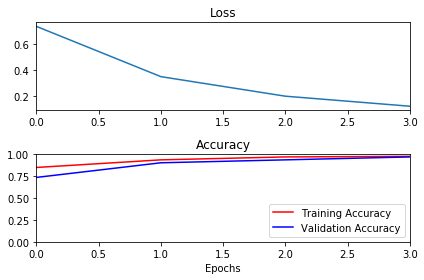

In [37]:
loss_plot = plt.subplot(211)
loss_plot.set_title('Loss')
loss_plot.plot(batches, loss_epoch)
loss_plot.set_xlim([batches[0], batches[-1]])
acc_plot = plt.subplot(212)
acc_plot.set_title('Accuracy')
acc_plot.plot(batches, train_acc_epoch, 'r', label='Training Accuracy')
acc_plot.plot(batches, valid_acc_epoch, 'b', label='Validation Accuracy')
acc_plot.set_xlabel('Epochs')
acc_plot.set_ylim([0, 1.0])
acc_plot.set_xlim([batches[0], batches[-1]])
acc_plot.legend(loc=4)
plt.tight_layout()
plt.show()

In [46]:
display(HTML("<table><tr><td>Origin image</td><td>Model graph</td></tr> <tr><td><img src='./img/Model_architecture_2.PNG' style='width: 700px;'></td><td><img src='./img/Model_architecture.png' style='width: 700px;'></td></tr></table>"))

Origin image,Model graph
,


In [39]:
show_graph(g)